# Prédiction de la consommation totale d'énergie

Nous devons prédire les émissions de CO2, hors nous n'avons pour cette étude que des quantités de gaz à effet de serre,<br>
sachant que ceux-ci sont composés de CO2 à environ 80%, nous simplifierons donc en considérant que les émissions de gaz<br>
à effet de serre sont équivalentes aux émissions de CO2.


In [1]:
# installation des modules necessaires
#!pip install shap graphviz


## chargement des bibliothèques

In [2]:
#import des modules necessaires
import os
import time
import datetime as dt
import requests
import shutil
import math

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn import set_config
set_config(print_changed_only=False)


## Définition des fonctions

In [3]:
# Création du dossier export
def CreationDir(dossierExport):
    if not os.path.exists(dossierExport):
        os.makedirs(dossierExport)

In [4]:
def delFeature(df,Feat2del=0):
    """Efface les features qui n'ont qu'une seule valeur"""
    if Feat2del == 0 :
        tmp = df.nunique()
        cols=tmp[tmp==1].index
        df.drop(columns=cols, inplace=True)
        colonnes = [col for col in cols]
        print('Liste des colonnes inutiles supprimées :',colonnes)
    else:
        for feat in Feat2del:
            if (feat in df.columns):
                df.drop(columns=feat, inplace=True)
            else:
                print('colonne',feat,'inexistante !')
        print('Liste des colonnes supprimées :',Feat2del)


In [5]:
def delIndividus(Datas,Indexes):
    """
    # Purge d'individus 
    # Liste des paramètres :
    #  - Data       : nom du dataframe a modifier
    #  - Indexes    : indexes a purger [liste des indexes]
    """
    print('------------------ Purge des individus ------------------')
    if len(Indexes) > 0:
            #récupération du nom du dataframe
            nomData = [name for name in globals() if globals()[name] is Datas]
            nomDf = ''.join(nomData)
            print('\n-- suppression de ',len(Indexes),' indexes du DataFrame ',nomDf)
            Datas.drop(Indexes, inplace=True)
    else:
            print('aucun index a supprimer !')

In [6]:
def graphResult(X,reel,pred,X_name=""):
    dfMod = pd.DataFrame()
    dfMod['X']=X
    dfMod['Reel']=reel
    dfMod['Pred']=pred
    titre=str(Cible[0])+""
    ylabel=str(Cible[0])+" "+str(Cible[2])

    dfMod=dfMod.sort_values(by=['X'])
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    plt.scatter(dfMod['X'], dfMod['Reel'], s=5, color="blue", label="réel")
    plt.plot(dfMod['X'], dfMod['Pred'], lw=1.5, color="red", label="prédiction")
    plt.title(titre, fontsize=14, pad=25)
    plt.ylabel(ylabel, fontsize=10)
    if X_name != "":
        plt.xlabel(X_name, fontsize=10)
    plt.legend()
    ax2 = fig.add_subplot(122)
    plt.scatter( dfMod['Reel'], dfMod['Pred'], s=5, color="blue", label="réel")
    plt.title("Confrontation prédictions", fontsize=14, pad=25)
    plt.ylabel('Valeurs prédites', fontsize=10)
    plt.xlabel('Valeurs réelles', fontsize=10)
    plt.show()

In [7]:
def scores(model,X_train,X_test,y_train,y_test,y_pred):
    print(f"X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
    print(f"X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
    print("")
    print(f"Score train:{round(model.score(X_train,y_train),5)}")
    print(f"Score test:{round(model.score(X_test,y_test),5)}")
    print(f"R2  :{round(r2_score(y_test, y_pred),5)}")
    print(f"Mse :{round(mean_squared_error(y_test, y_pred),5)}")
    print(f"Rmse:{round(math.sqrt(mean_squared_error(y_test, y_pred)),5)}")


In [8]:
def ImportanceFeaturesMDI(model,Affnum=0):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    feature_names=preprocessor.fit_transform(X_train).columns
    changeChars=[('pipeline-1__',''),('pipeline-2__','')]
    for rech, trgt in changeChars:
        feature_names = [name.replace(rech,trgt) for name in feature_names]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances.sort_values(ascending=False, inplace=True)
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)

    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Importance des Features avec MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    if Affnum != 0:
        print('Visualisation de l\importance des variables sous forme numérique :')
        print(forest_importances.sort_values(ascending=False))
        print('')

## Chargement des données

In [9]:
Id_Random=66
dossierData='Datas'
dossierExport=dossierData+'/'
fichierimport=dossierData+'/Data_cleared.csv'

In [10]:
# Chargement des données
dfDataInput_filtered = pd.read_csv(fichierimport, sep='|', lineterminator='\n', encoding='utf-8')

## Choix de la cible

In [11]:
Cible=['Utilisation Totale d\'énergie du site','SiteEnergyUse(kBtu)','(kBtu)']

## Vérification des données

In [12]:
dfDataInput_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OSEBuildingID          1446 non-null   int64  
 1   BuildingType           1446 non-null   object 
 2   PrimaryPropertyType    1446 non-null   object 
 3   ZipCode                1443 non-null   float64
 4   CouncilDistrictCode    1446 non-null   int64  
 5   Neighborhood           1446 non-null   object 
 6   Latitude               1446 non-null   float64
 7   Longitude              1446 non-null   float64
 8   NumberofBuildings      1446 non-null   float64
 9   NumberofFloors         1446 non-null   int64  
 10  PropertyGFATotal       1446 non-null   int64  
 11  ENERGYSTARScore        929 non-null    float64
 12  SiteEUI(kBtu/sf)       1446 non-null   float64
 13  SourceEUI(kBtu/sf)     1446 non-null   float64
 14  SiteEnergyUse(kBtu)    1446 non-null   float64
 15  Stea

In [13]:
mylist = list(dfDataInput_filtered.select_dtypes(include=['object']).columns)
print(mylist)
for feat in mylist:
    print('=========================',feat,'=========================')
    print(dfDataInput_filtered[feat].value_counts())

['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
========================= BuildingType =========================
BuildingType
NonResidential        1349
Nonresidential COS      69
Campus                  17
SPS-District K-12       10
Nonresidential WA        1
Name: count, dtype: int64
========================= PrimaryPropertyType =========================
PrimaryPropertyType
Small- and Mid-Sized Office    281
Other                          222
Warehouse                      183
Large Office                   157
Mixed Use Property             106
Retail Store                    84
Hotel                           69
Worship Facility                68
Distribution Center             52
K-12 School                     50
Supermarket / Grocery Store     38
Medical Office                  35
Self-Storage Facility           28
University                      21
Senior Care Community           19
Refrigerated Warehouse          12
Restaurant                      11
Laboratory        

Nous pouvons voir la présence de quartiers en doublons à cause de la casse 

In [14]:
# modification de la casse des noms de quartiers
dfDataInput_filtered['Neighborhood']=dfDataInput_filtered['Neighborhood'].str.upper()
dfDataInput_filtered['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                 319
GREATER DUWAMISH         318
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    139
EAST                     105
NORTHEAST                 94
NORTHWEST                 76
BALLARD                   59
NORTH                     58
CENTRAL                   43
DELRIDGE                  39
SOUTHEAST                 29
SOUTHWEST                 28
Name: count, dtype: int64

In [15]:
# modification de l'unique valeur 'BuildingType' 'Nonresidential WA' en 'Nonresidential'
dfDataInput_filtered.loc[dfDataInput_filtered['BuildingType']=='Nonresidential WA','BuildingType']='NonResidential'
dfDataInput_filtered['BuildingType'].value_counts()

BuildingType
NonResidential        1350
Nonresidential COS      69
Campus                  17
SPS-District K-12       10
Name: count, dtype: int64

In [16]:
dfDataInput_filtered.shape

(1446, 30)

## Selection des données

In [17]:
y = dfDataInput_filtered[Cible[1]]
X = dfDataInput_filtered.drop(Cible[1], axis=1)

## Premier modèle BaseLine (LinearRegression)

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.54776
Score test:0.54963
R2  :0.54963
Mse :31006241748536.684
Rmse:5568324.86018


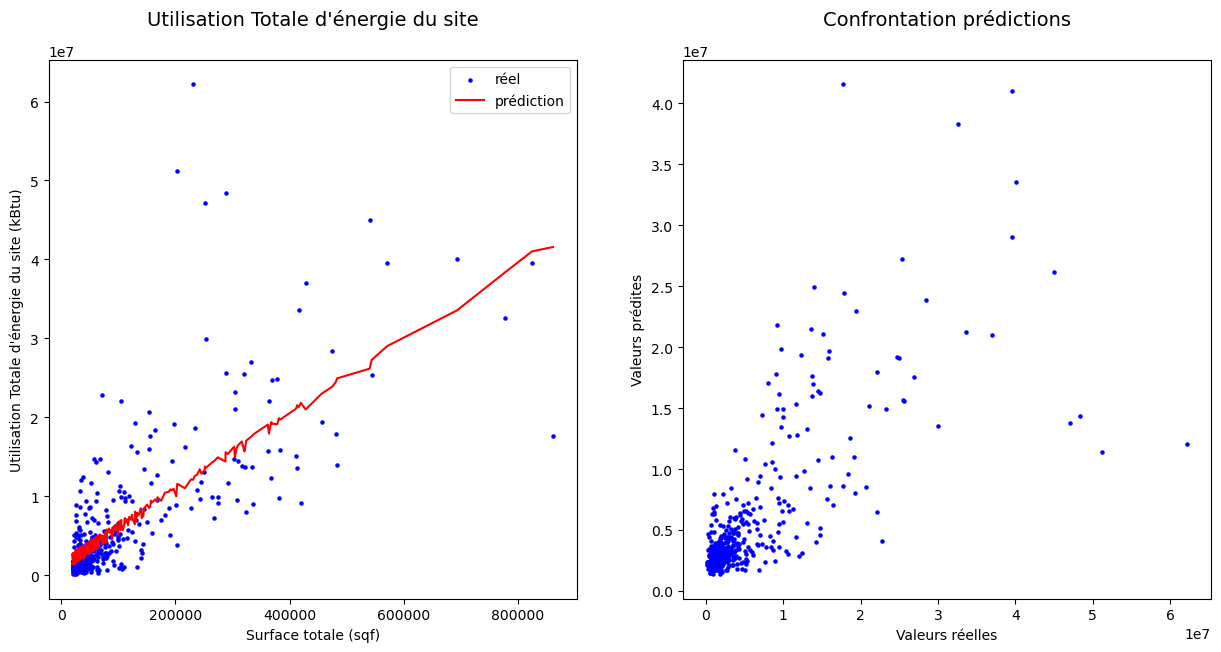

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random)

features=['PropertyGFATotal','AgeBuilding']
pipe_features=make_pipeline(SimpleImputer())
preprocessor=make_column_transformer((pipe_features, features))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')


## Amélioration du feature engineering

### Modèle avec normalisation (StandardScaler)

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.54776
Score test:0.54963
R2  :0.54963
Mse :31006241748536.684
Rmse:5568324.86018


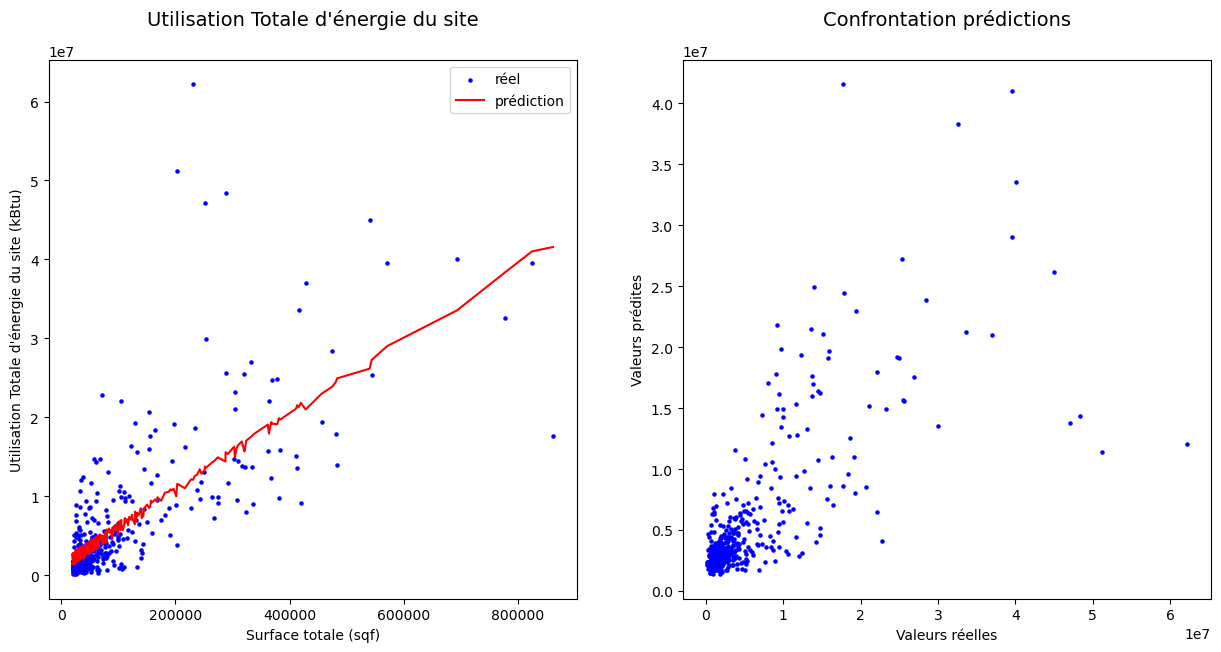

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random)

features=['PropertyGFATotal','AgeBuilding']
pipe_features=make_pipeline(SimpleImputer(), StandardScaler())
preprocessor=make_column_transformer((pipe_features, features))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')



### Augmentation du nombre de features

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.64572
Score test:0.58599
R2  :0.58599
Mse :28503269811129.05
Rmse:5338845.3631


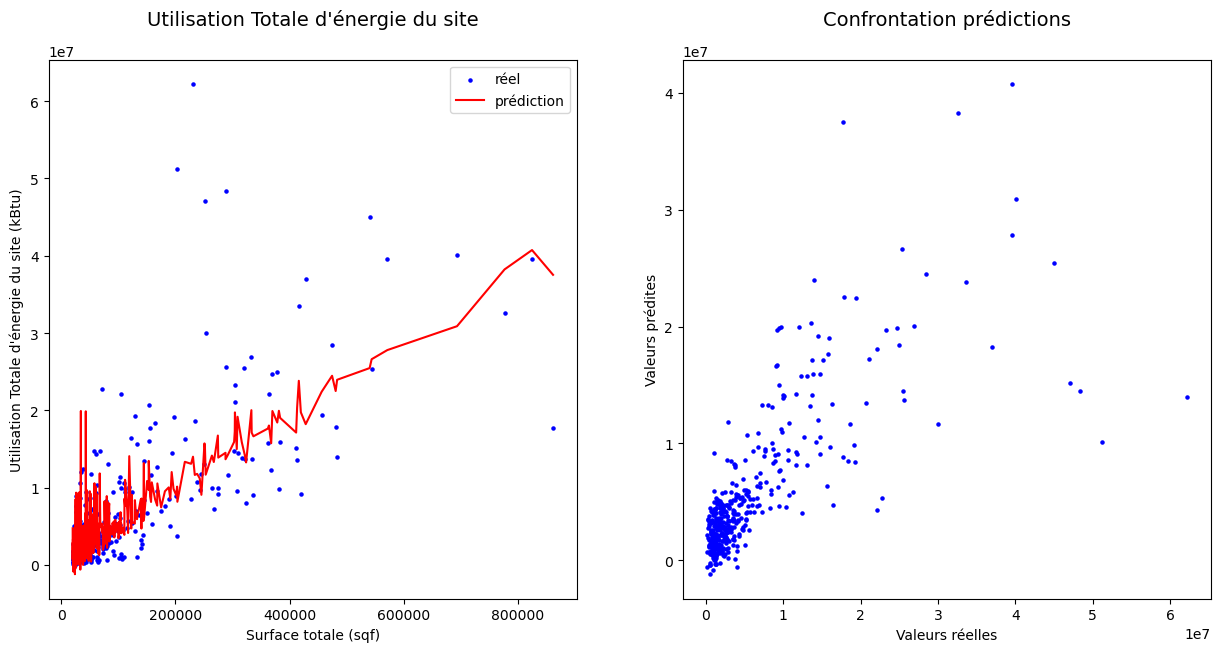

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')

### Ajout du mix énergetique des batiments

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.64961
Score test:0.58733
R2  :0.58733
Mse :28410710172250.727
Rmse:5330169.80707


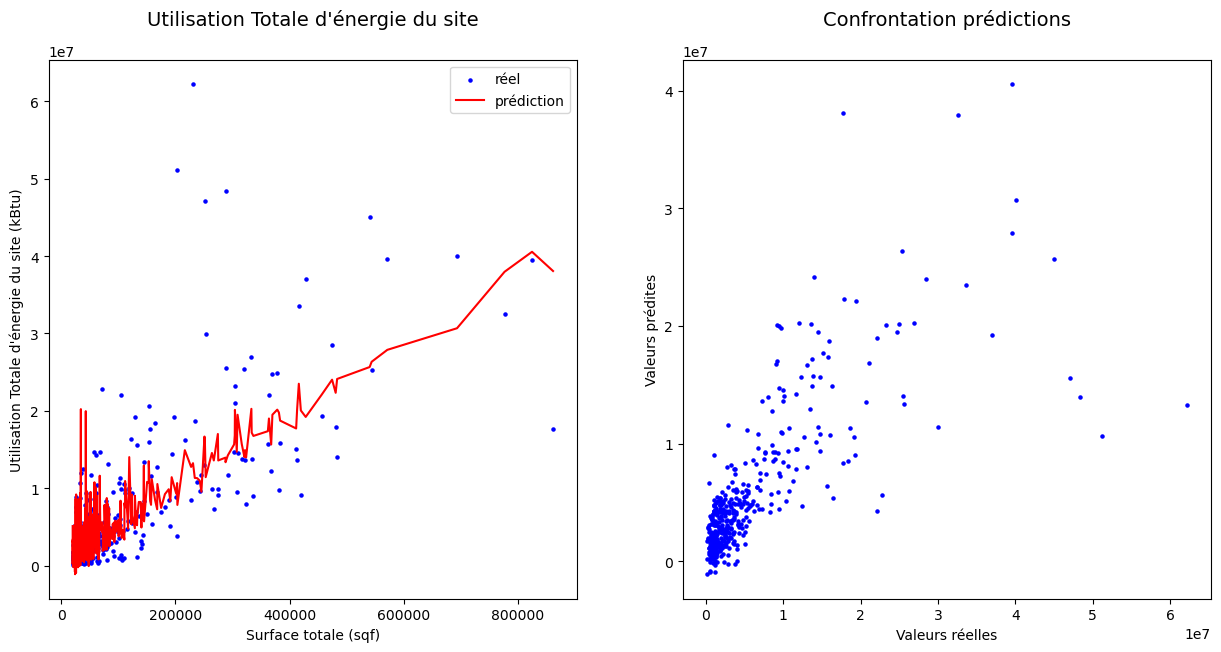

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')

## Simulation d'autres modèles et choix du modèle final

### Industrialisation de la recherche de solution

In [22]:
# définition des modèles testés et de leurs hyperparamètres
Modeles2Test=[[LinearRegression(),{
                  'linearregression__fit_intercept': [True, False],
                  'linearregression__copy_X': [True, False]}],
              [SVR(),{
                  'svr__gamma' : ['auto','scale'],
                  'svr__epsilon' : [0.001, 0.01, 0.1, 1],
                  'svr__C' : [0.001, 0.01, 0.1, 1, 10],
                  'svr__tol':[0.001]}],
              [Lasso(),{
                  'lasso__alpha':[1,0.1,0.01,0.001],
                  'lasso__max_iter':[1000],
                  'lasso__tol':[0.001]}],
              [Ridge(),{
                  'ridge__alpha':[1,0.1,0.01,0.001],
                  'ridge__max_iter':[1000],
                  'ridge__tol':[0.001]}],
              [ElasticNet(),{
                  'elasticnet__alpha': [1,0.1,0.01,0.001],
                  'elasticnet__max_iter': [1000],
                  'elasticnet__tol': [0.001]}],
              [GradientBoostingRegressor(),{
                  'gradientboostingregressor__n_estimators':[100, 500, 1000],
                  'gradientboostingregressor__max_depth': [None]}],
              [RandomForestRegressor(),{
                  'randomforestregressor__n_estimators': [100, 500, 1000],
                  'randomforestregressor__max_features': [None,"log2"],
                  'randomforestregressor__n_jobs': [-1],
                  'randomforestregressor__max_depth': [None]}]]

> définition des modèles testés et des paramètres a ajuster

In [23]:
def scores2(model,X_train,X_test,y_train,y_test,y_pred,temps):
    scoreTrain=round(model.score(X_train,y_train),5)
    scoreTest=round(model.score(X_test,y_test),5)
    mse=round(mean_squared_error(y_test, y_pred),5)
    rmse=round(math.sqrt(mean_squared_error(y_test, y_pred)),5)
    print(f"Temps d\'execution : {temps}s")
    print(f"Score train :{scoreTrain}")
    print(f"Score test  :{scoreTest}")
    print(f"Mse :{mse}")
    print(f"Rmse:{rmse}")
    return [scoreTrain,scoreTest,mse,rmse,temps]


In [24]:
def TestModeles(Donnees,Modeles2Test):
    y = Donnees[Cible[1]]
    X = Donnees.drop(Cible[1], axis=1)
    sortie=[]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) #, stratify=y

    features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                         'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)', 'NrjVap(pct)',
                         'NrjGaz(pct)']
    features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

    pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
    pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
    preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                         (pipe_categoriel, features_categorielles))

    for ModeleAndParams in Modeles2Test:
        Modele2Test=ModeleAndParams[0]
        Params2Test=ModeleAndParams[1]
        ModelName=str(Modele2Test)[:str(Modele2Test).rfind("(")]
        # teste modèle de base
        print(f"Modèle {ModelName} base : ")
        model=make_pipeline(preprocessor, Modele2Test)        # mise en place pipelne
        depart = time.time()                                  # début chrono
        model.fit(X_train, y_train)                           # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        y_pred=model.predict(X_test)                          # calcul prédictions
        scoreReturnBase=scores2(model,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # test modèle recherche param gridsearch
        print(f"Modèle {ModelName} grid : ")
        model2=make_pipeline(preprocessor, Modele2Test)       # mise en place pipelne
        #print(model2.get_params().keys())
        modelgd=GridSearchCV(model2, param_grid=Params2Test, verbose=0, n_jobs=-1, cv=5, refit=True)  # mise en place pipelne
        depart = time.time()                                  # début chrono
        modelgd.fit(X_train, y_train)                         # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        print(f"meilleurs paramètres : {modelgd.best_params_}")
        y_pred=modelgd.predict(X_test)                        # calcul prédictions
        scoreReturnGrd=scores2(modelgd,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # test modèle recherche param random
        print(f"Modèle {ModelName} random :")
        model3=make_pipeline(preprocessor, Modele2Test)       # mise en place pipelne
        #print(model2.get_params().keys())
        modelrd=RandomizedSearchCV(model3, param_distributions=Params2Test, verbose=0, n_iter=3, cv=5, refit=True)  # mise en place pipelne
        depart = time.time()                                  # début chrono
        modelrd.fit(X_train, y_train)                         # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        print(f"meilleurs paramètres : {modelrd.best_params_}")
        y_pred=modelrd.predict(X_test)                        # calcul prédictions
        scoreReturnRnd=scores2(modelrd,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # récupération des paramètresabs
        sortie.append([ModelName,scoreReturnBase[0],scoreReturnGrd[0],scoreReturnRnd[0],
                        scoreReturnBase[1],scoreReturnGrd[1],scoreReturnRnd[1],
                        scoreReturnBase[2],scoreReturnGrd[2],scoreReturnRnd[2],
                        scoreReturnBase[3],scoreReturnGrd[3],scoreReturnRnd[3],
                        scoreReturnBase[4],scoreReturnGrd[4],scoreReturnRnd[4]])
    return sortie

Modèle LinearRegression base : 
Temps d'execution : 0.02s
Score train :0.64961
Score test  :0.58733
Mse :28410710172250.727
Rmse:5330169.80707


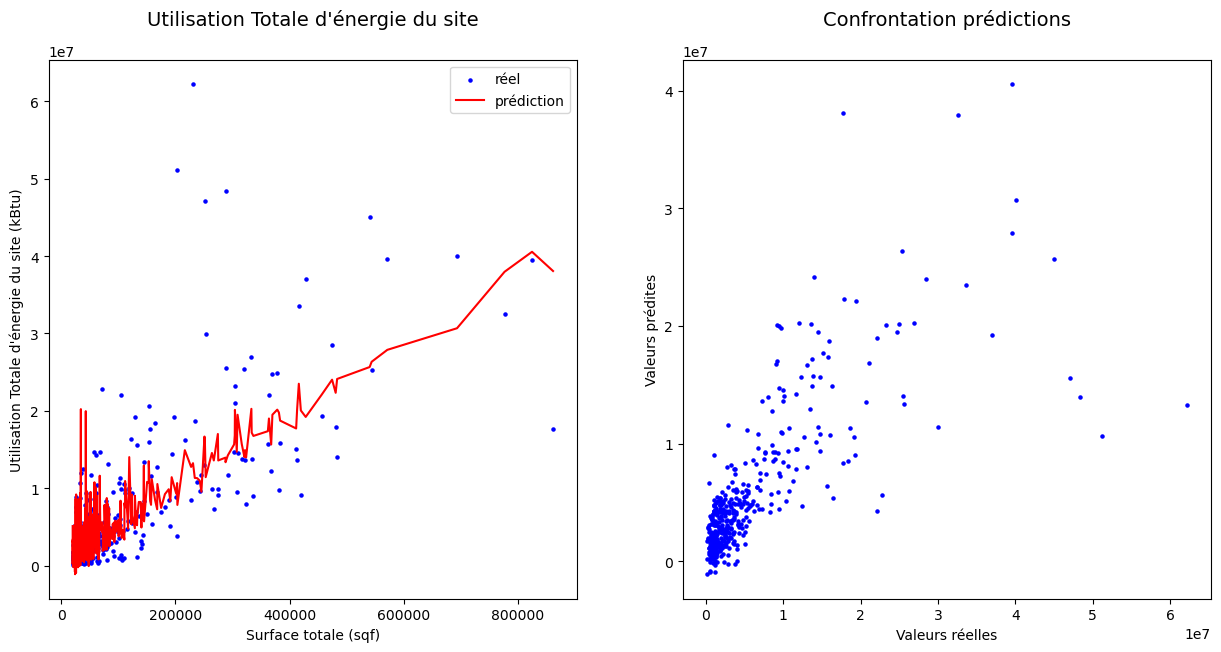

Modèle LinearRegression grid : 
meilleurs paramètres : {'linearregression__copy_X': True, 'linearregression__fit_intercept': False}
Temps d'execution : 1.311s
Score train :0.64961
Score test  :0.58733
Mse :28410594004698.387
Rmse:5330158.90989


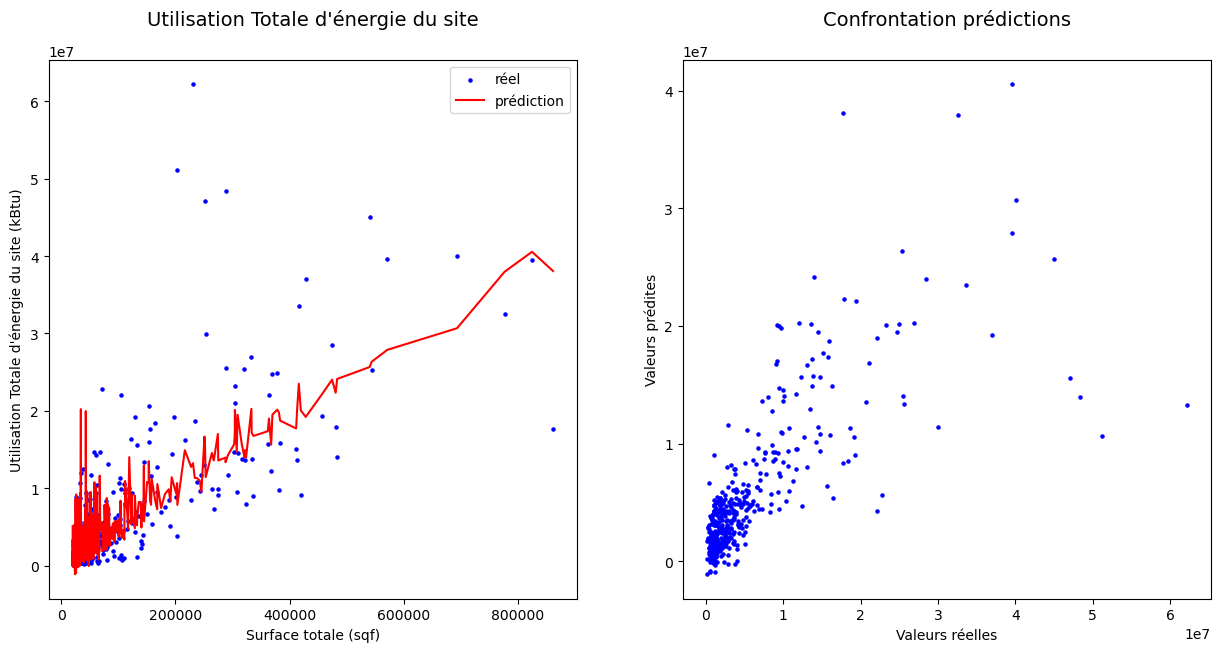

Modèle LinearRegression random :
meilleurs paramètres : {'linearregression__fit_intercept': False, 'linearregression__copy_X': True}
Temps d'execution : 0.298s
Score train :0.64961
Score test  :0.58733
Mse :28410594004698.387
Rmse:5330158.90989


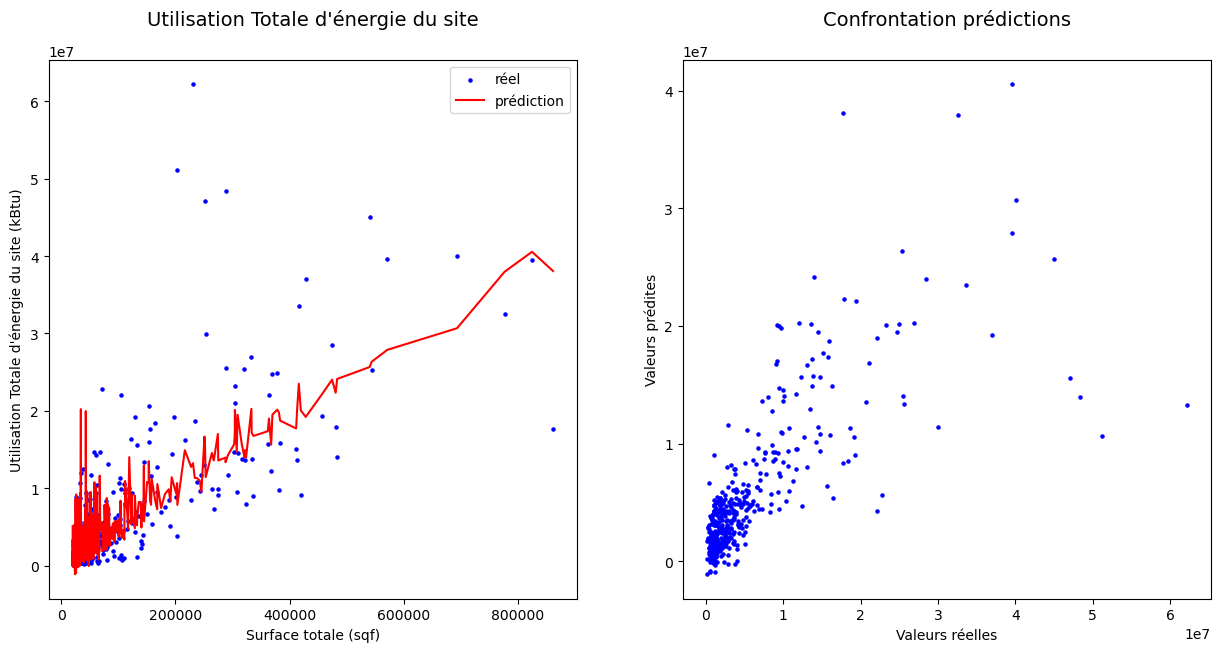

Modèle SVR base : 
Temps d'execution : 0.042s
Score train :-0.1458
Score test  :-0.14608
Mse :78903737879054.58
Rmse:8882777.59932


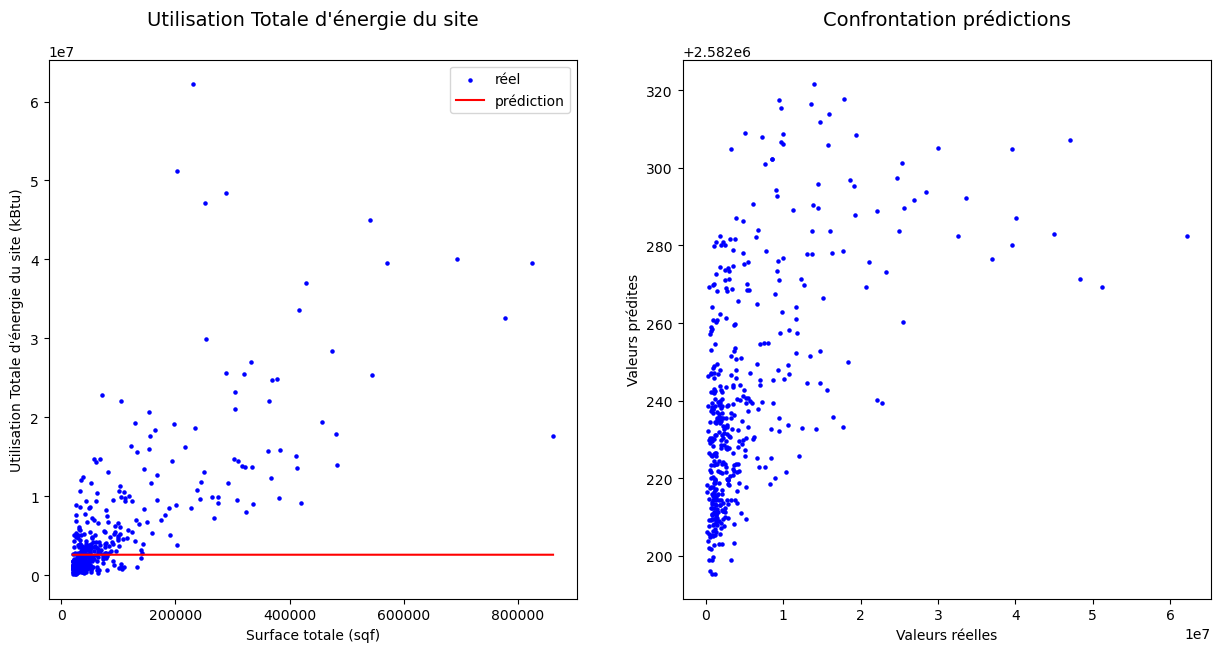

Modèle SVR grid : 
meilleurs paramètres : {'svr__C': 10, 'svr__epsilon': 0.001, 'svr__gamma': 'scale', 'svr__tol': 0.001}
Temps d'execution : 2.209s
Score train :-0.14574
Score test  :-0.14603
Mse :78899804048168.89
Rmse:8882556.16634


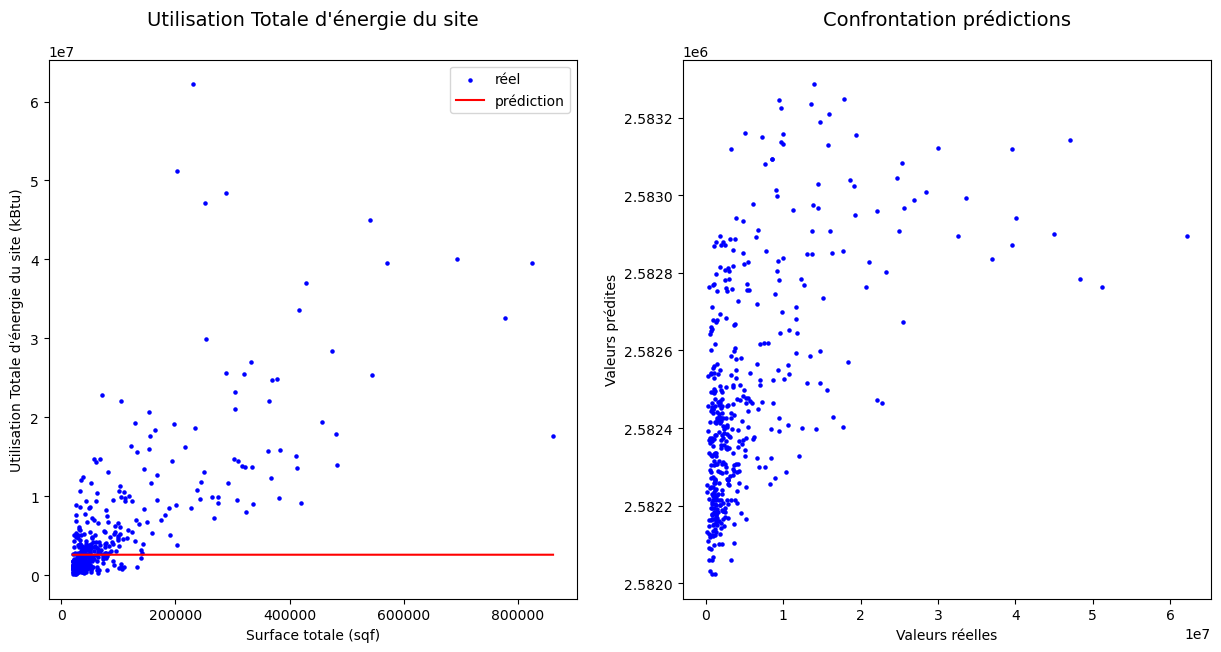

Modèle SVR random :
meilleurs paramètres : {'svr__tol': 0.001, 'svr__gamma': 'auto', 'svr__epsilon': 0.001, 'svr__C': 10}
Temps d'execution : 0.716s
Score train :-0.14575
Score test  :-0.14604
Mse :78900658392928.66
Rmse:8882604.25736


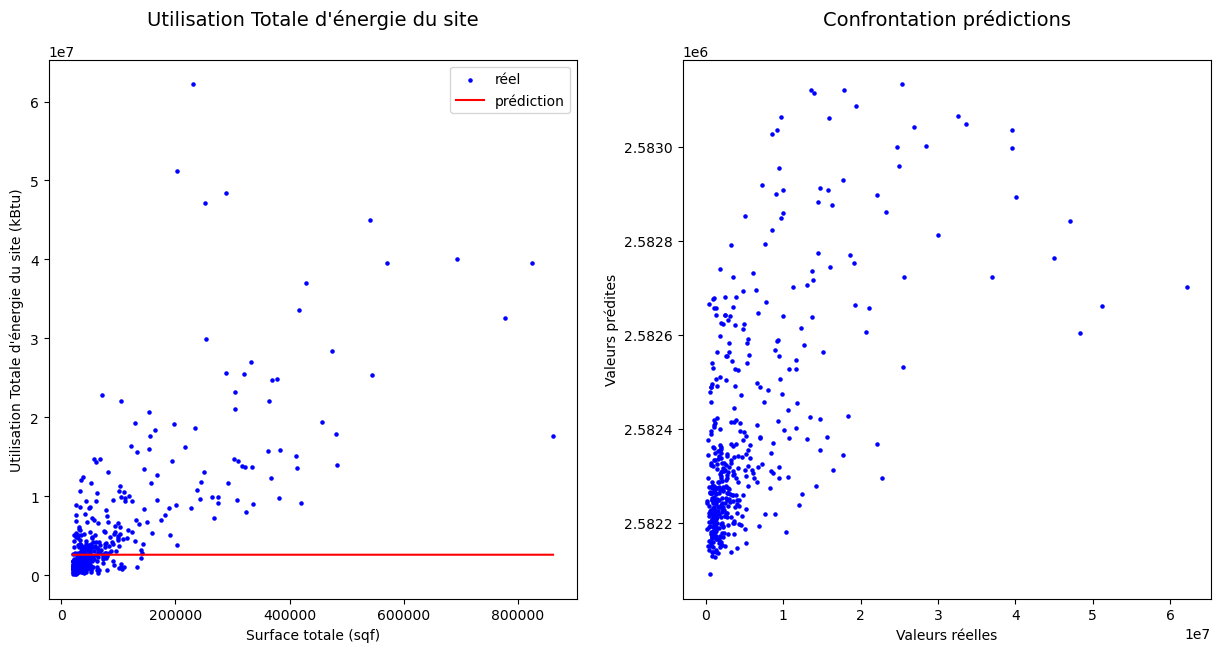

Modèle Lasso base : 
Temps d'execution : 0.174s
Score train :0.64961
Score test  :0.58733
Mse :28410676973110.695
Rmse:5330166.69281


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1677546967336690.0, tolerance: 6927639625736.229
  model = cd_fast.sparse_enet_coordinate_descent(


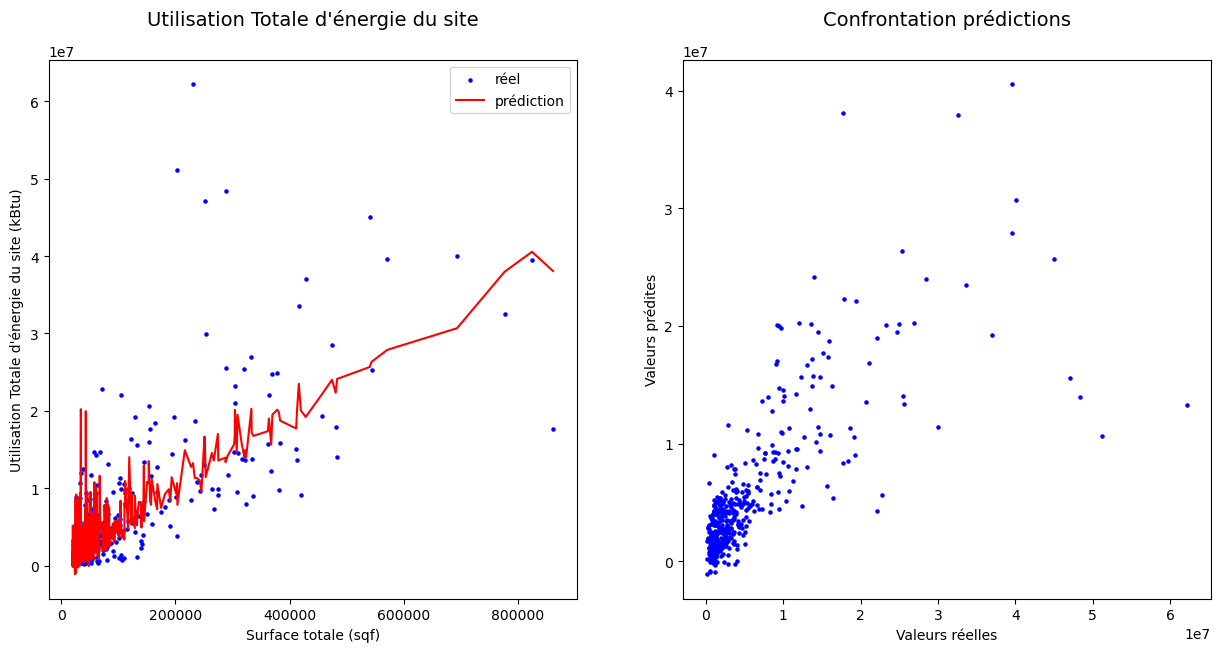

Modèle Lasso grid : 


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 908112991000054.0, tolerance: 57460206441860.805
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861789176519238.0, tolerance: 56445562328950.39
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452434526852558.0, tolerance: 56085459870029.8
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: Converg

meilleurs paramètres : {'lasso__alpha': 1, 'lasso__max_iter': 1000, 'lasso__tol': 0.001}
Temps d'execution : 0.795s
Score train :0.64961
Score test  :0.58733
Mse :28410676973110.695
Rmse:5330166.69281


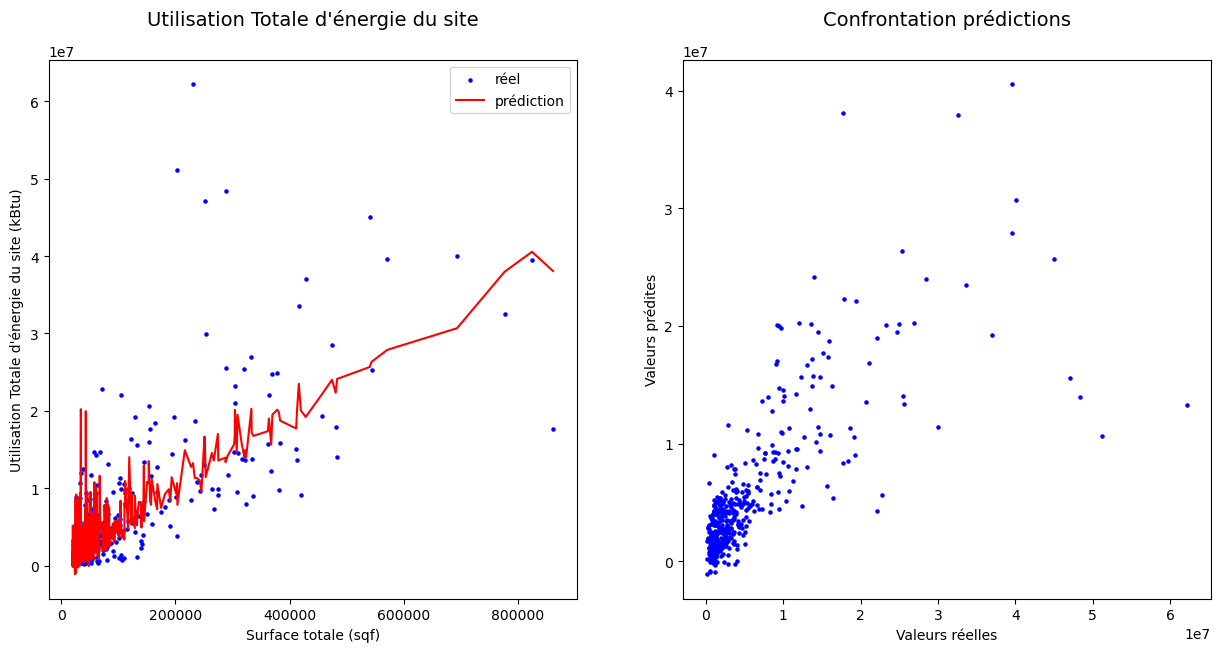

Modèle Lasso random :


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452434526852558.0, tolerance: 56085459870029.8
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2083047871084489.0, tolerance: 50751514410005.85
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861789176519238.0, tolerance: 56445562328950.39
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: Converg

meilleurs paramètres : {'lasso__tol': 0.001, 'lasso__max_iter': 1000, 'lasso__alpha': 1}
Temps d'execution : 2.732s
Score train :0.64961
Score test  :0.58733
Mse :28410676973110.695
Rmse:5330166.69281


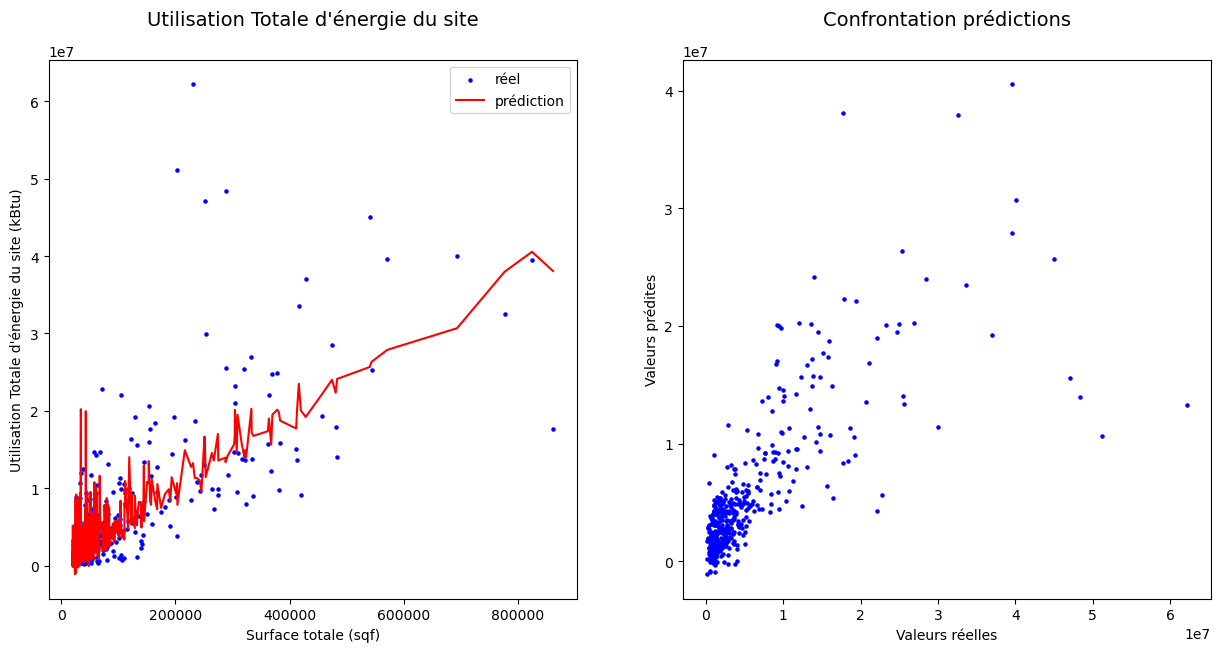

Modèle Ridge base : 
Temps d'execution : 0.015s
Score train :0.64867
Score test  :0.5911
Mse :28151435130709.613
Rmse:5305792.60155


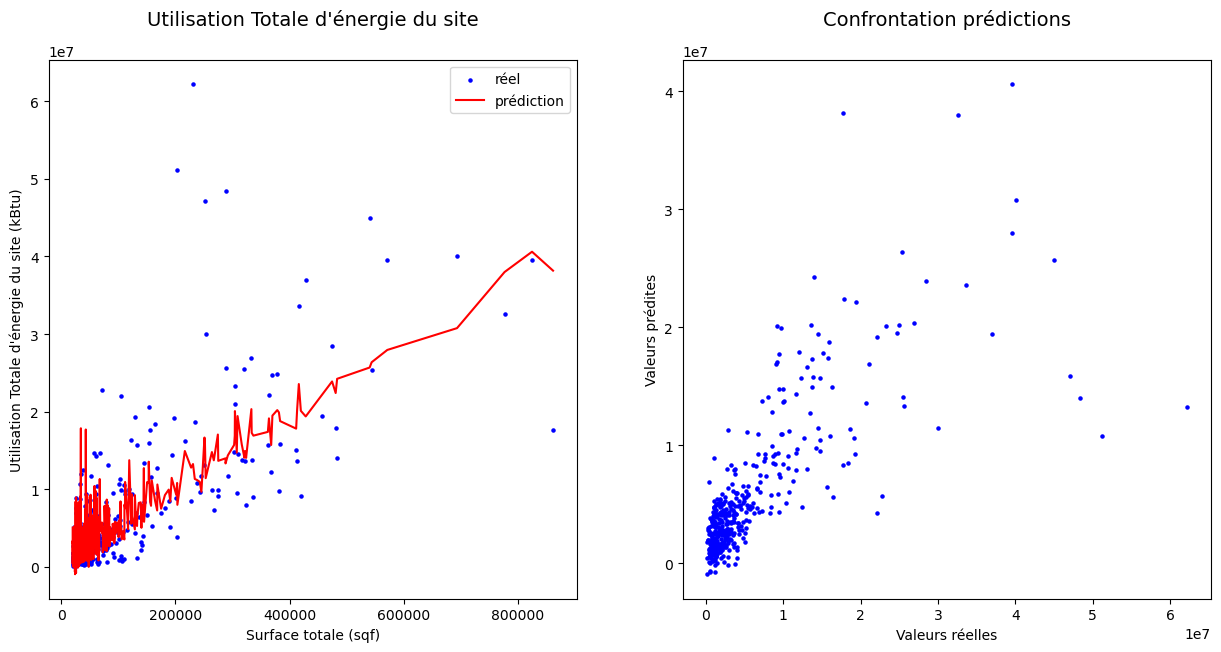

Modèle Ridge grid : 
meilleurs paramètres : {'ridge__alpha': 1, 'ridge__max_iter': 1000, 'ridge__tol': 0.001}
Temps d'execution : 0.135s
Score train :0.64861
Score test  :0.59134
Mse :28135086453865.477
Rmse:5304251.73364


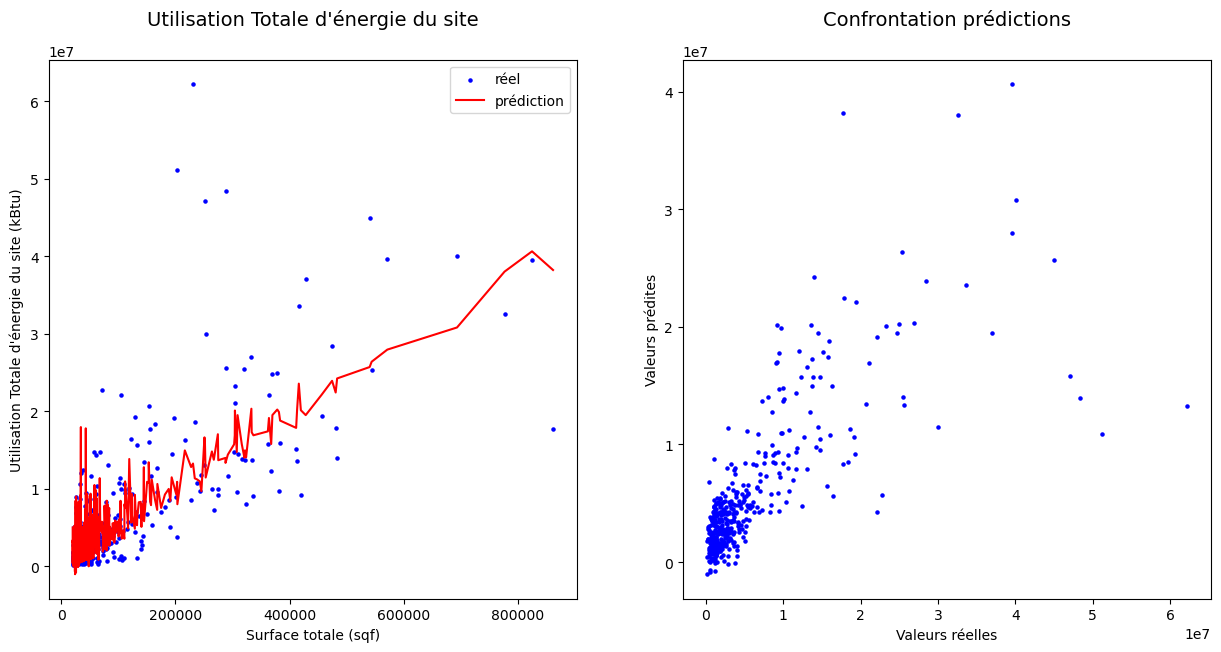

Modèle Ridge random :
meilleurs paramètres : {'ridge__tol': 0.001, 'ridge__max_iter': 1000, 'ridge__alpha': 1}
Temps d'execution : 0.352s
Score train :0.64861
Score test  :0.59134
Mse :28135086453865.477
Rmse:5304251.73364


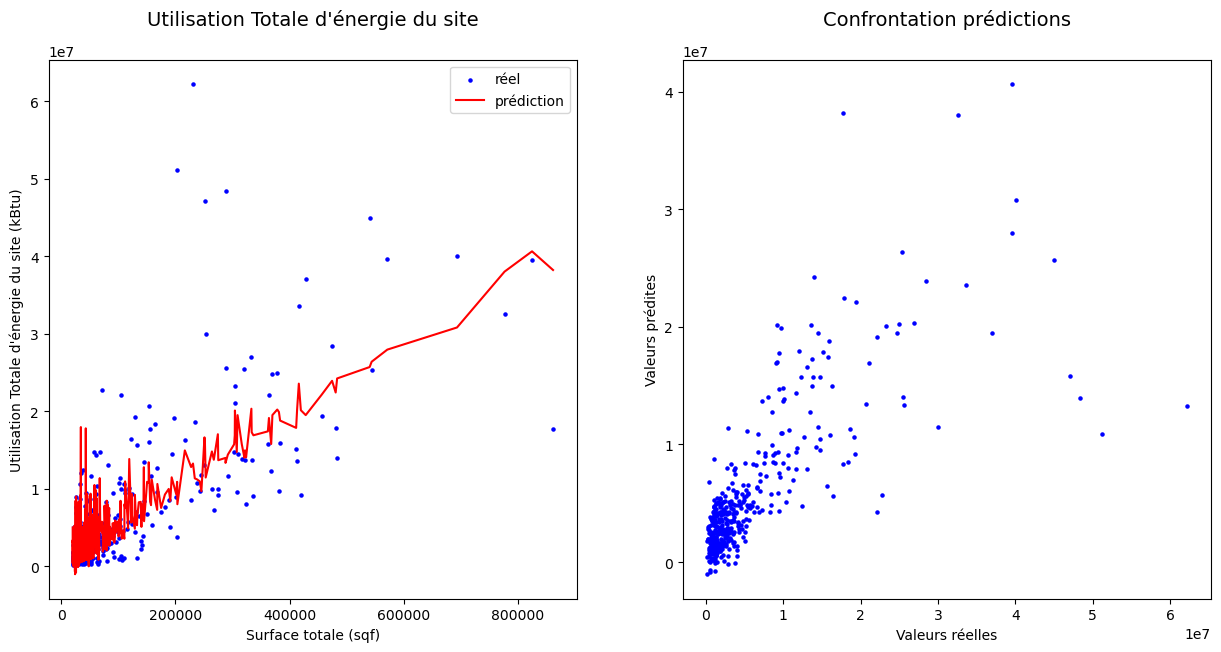

Modèle ElasticNet base : 
Temps d'execution : 0.016s
Score train :0.54662
Score test  :0.50556
Mse :34040436658398.15
Rmse:5834418.27935


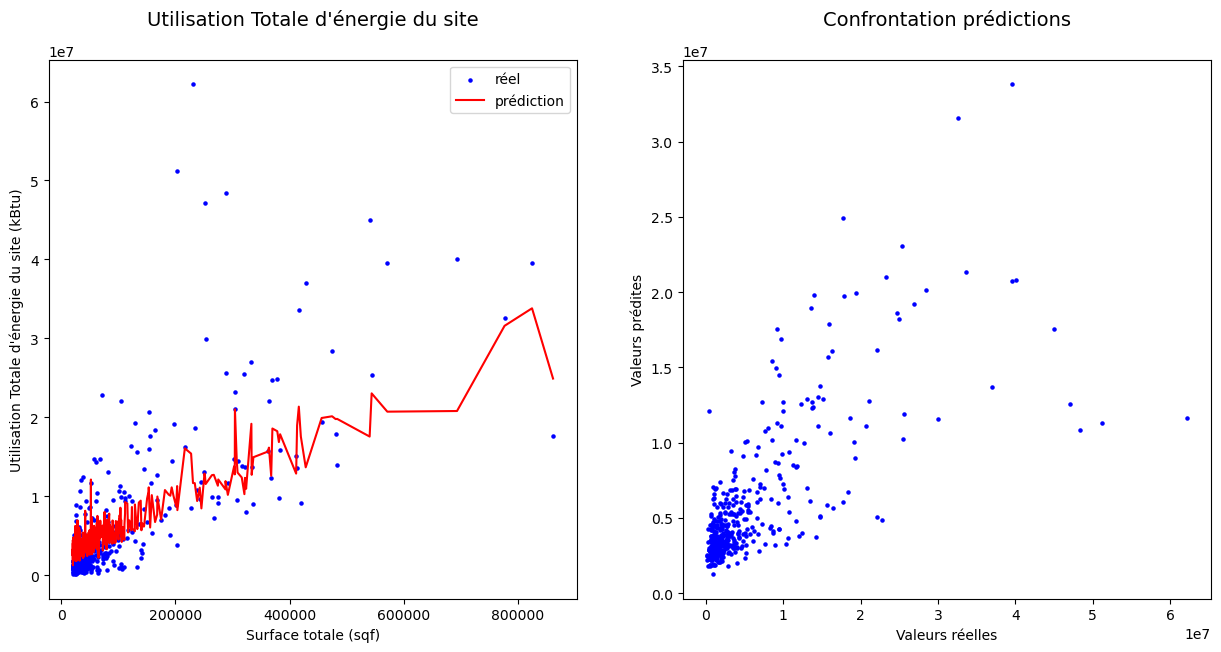

Modèle ElasticNet grid : 


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8097929480029644.0, tolerance: 56445562328950.39
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8358458473518467.0, tolerance: 50751514410005.85
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8311725867641525.0, tolerance: 56445562328950.39
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: Conve

meilleurs paramètres : {'elasticnet__alpha': 0.01, 'elasticnet__max_iter': 1000, 'elasticnet__tol': 0.001}
Temps d'execution : 1.145s
Score train :0.64193
Score test  :0.59524
Mse :27866027163913.504
Rmse:5278828.19989


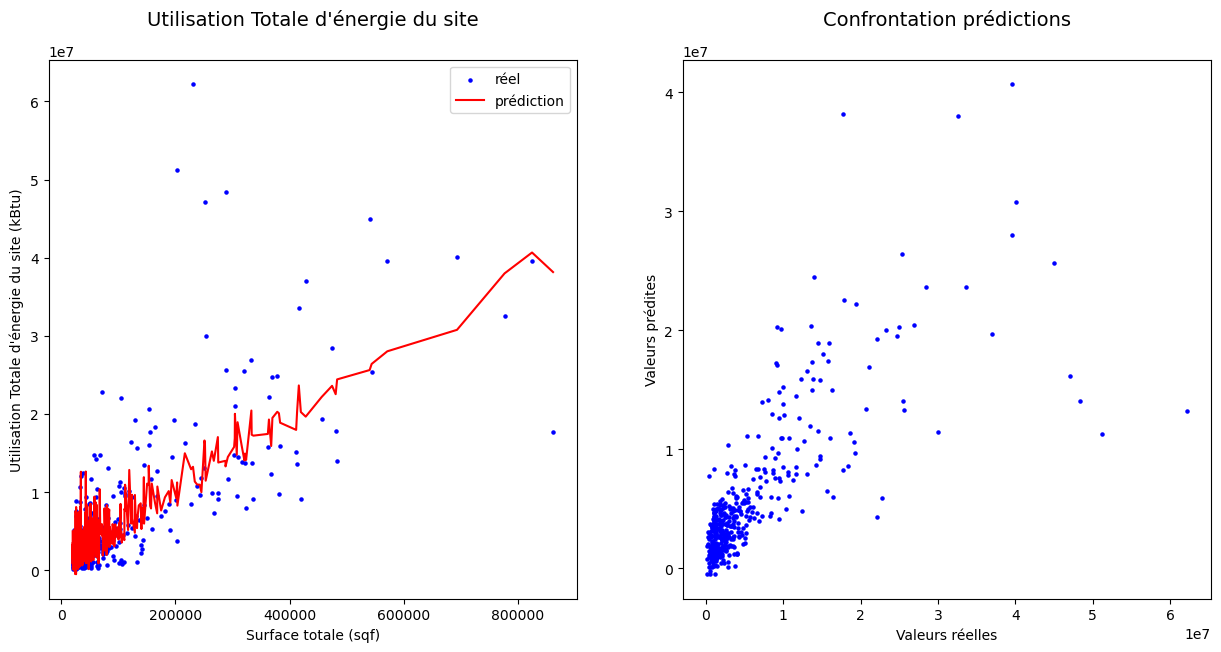

Modèle ElasticNet random :


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0604446936650326e+16, tolerance: 56085459870029.8
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8633384420877393.0, tolerance: 50751514410005.85
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8311725867641525.0, tolerance: 56445562328950.39
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: Co

meilleurs paramètres : {'elasticnet__tol': 0.001, 'elasticnet__max_iter': 1000, 'elasticnet__alpha': 0.01}
Temps d'execution : 2.29s
Score train :0.64193
Score test  :0.59524
Mse :27866027163913.504
Rmse:5278828.19989


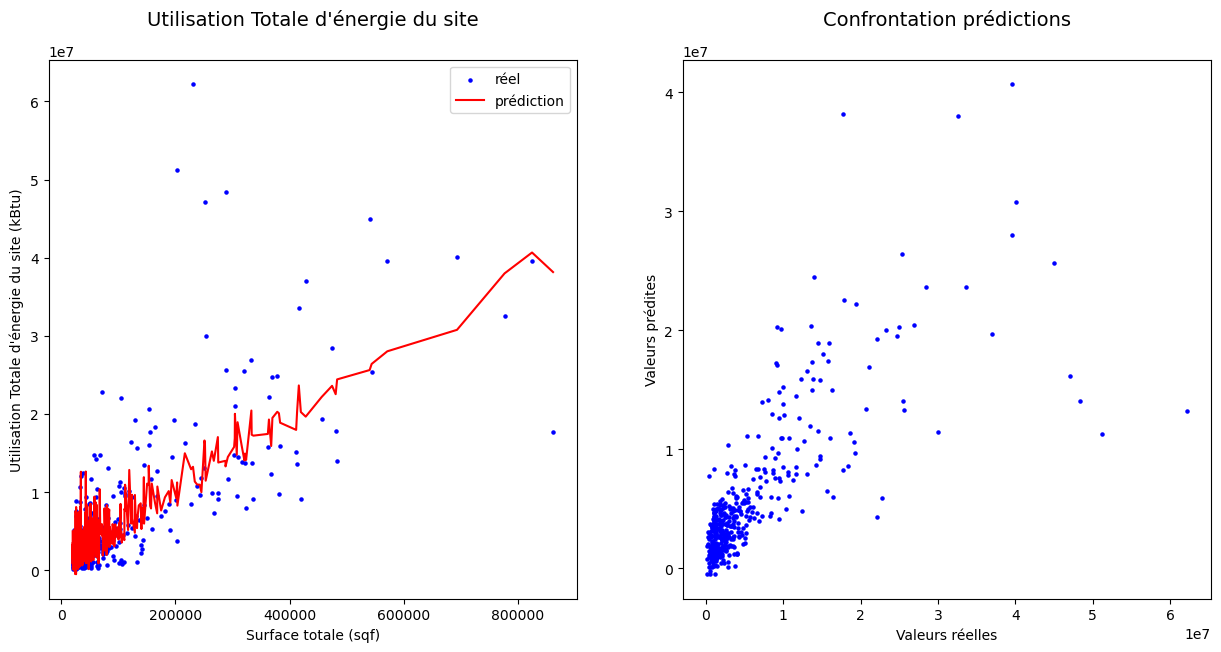

Modèle GradientBoostingRegressor base : 
Temps d'execution : 0.33s
Score train :0.88101
Score test  :0.62814
Mse :25601408864124.57
Rmse:5059783.47996


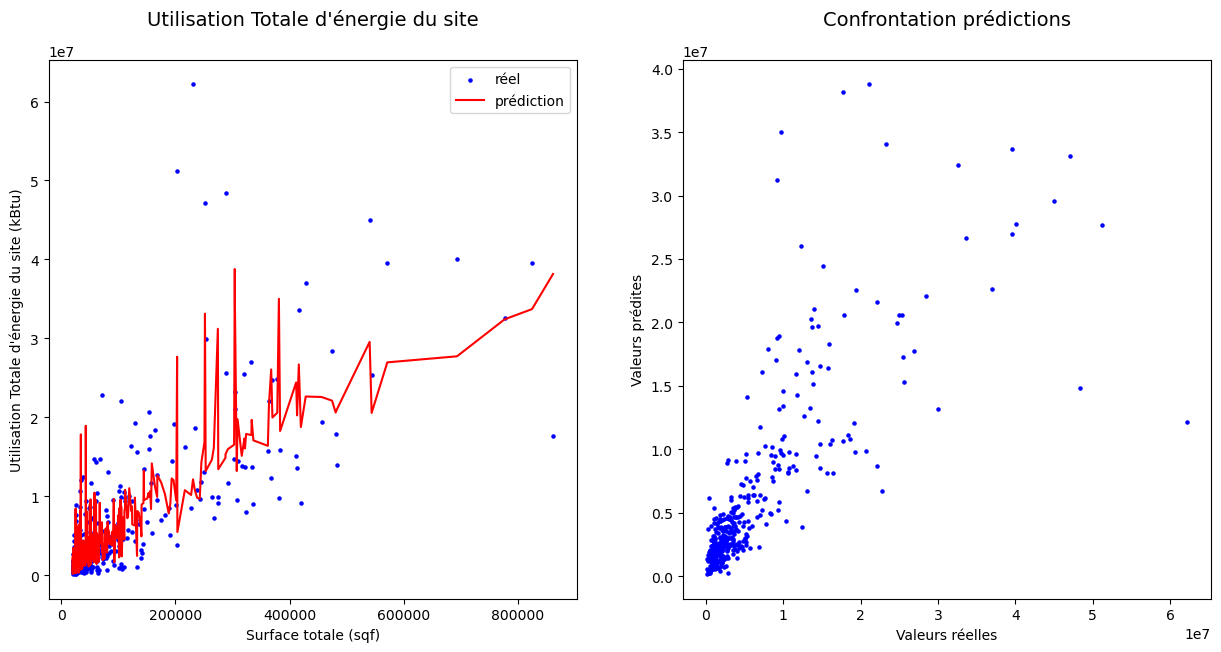

Modèle GradientBoostingRegressor grid : 
meilleurs paramètres : {'gradientboostingregressor__max_depth': None, 'gradientboostingregressor__n_estimators': 100}
Temps d'execution : 32.057s
Score train :1.0
Score test  :0.28976
Mse :48897286721647.13
Rmse:6992659.48847


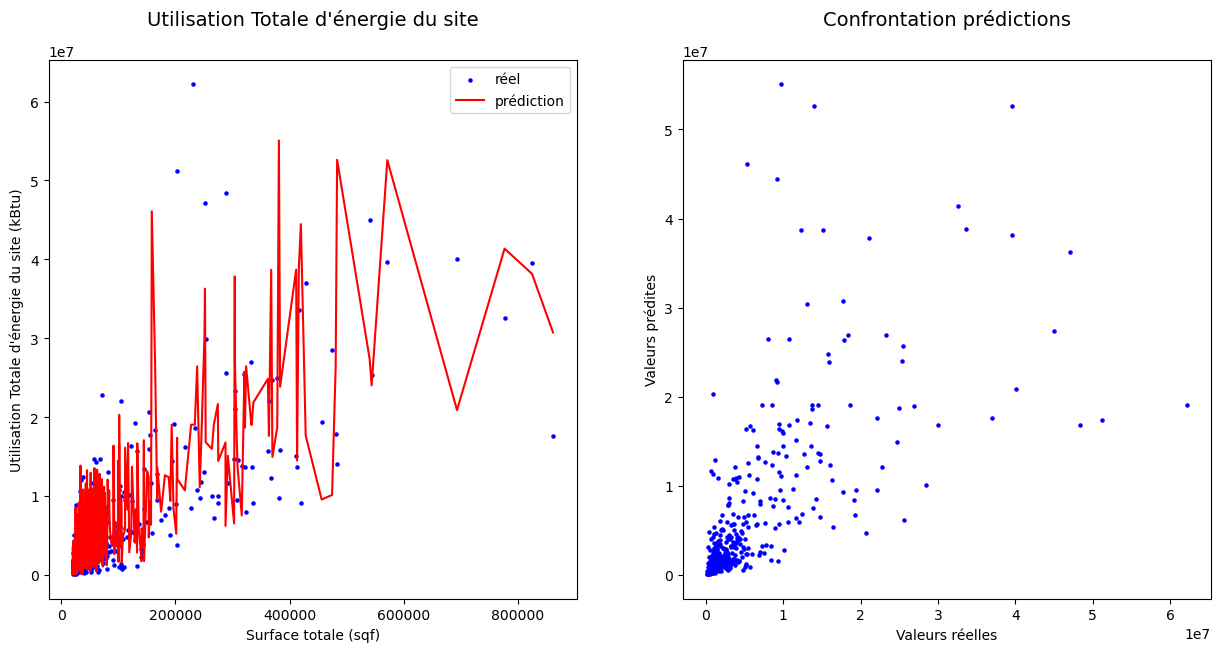

Modèle GradientBoostingRegressor random :
meilleurs paramètres : {'gradientboostingregressor__n_estimators': 100, 'gradientboostingregressor__max_depth': None}
Temps d'execution : 83.389s
Score train :1.0
Score test  :0.29503
Mse :48534599371265.09
Rmse:6966677.78581


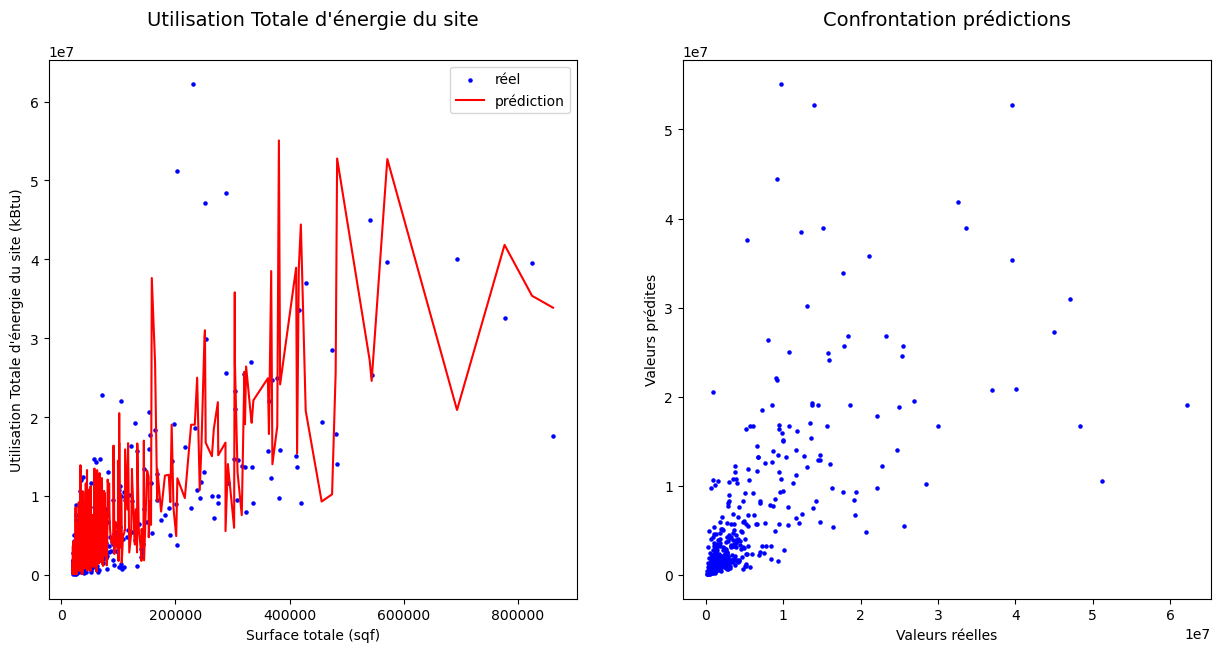

Modèle RandomForestRegressor base : 
Temps d'execution : 1.504s
Score train :0.95021
Score test  :0.62458
Mse :25846574426258.336
Rmse:5083952.63808


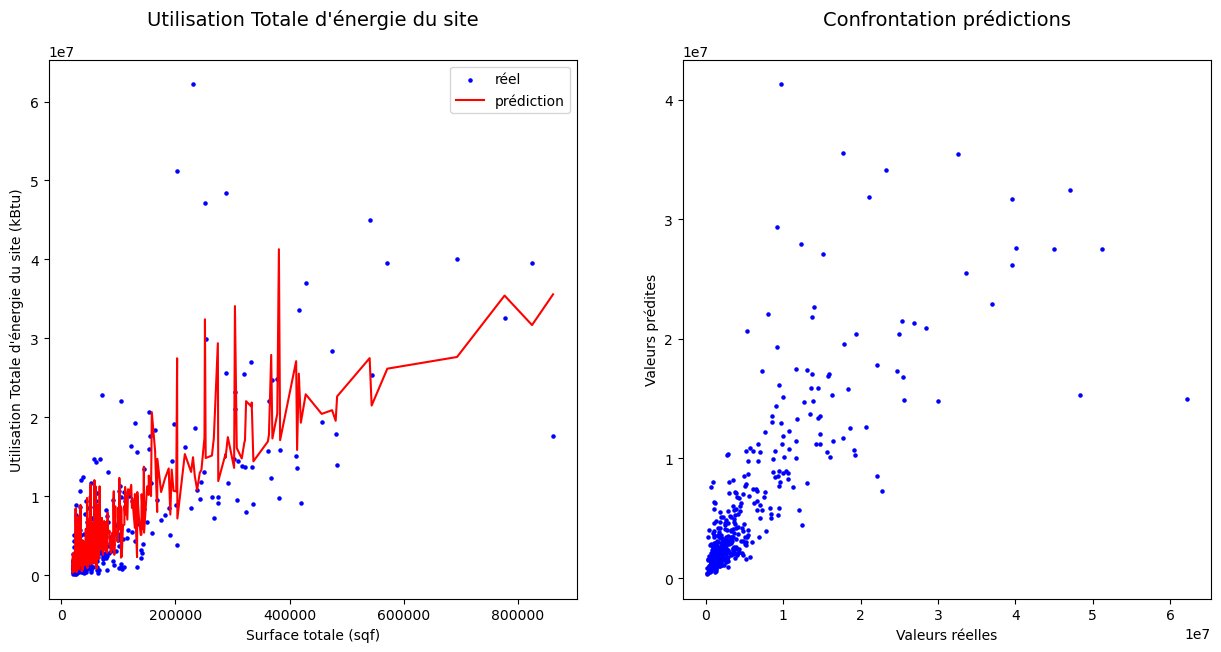

Modèle RandomForestRegressor grid : 
meilleurs paramètres : {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': None, 'randomforestregressor__n_estimators': 500, 'randomforestregressor__n_jobs': -1}
Temps d'execution : 28.89s
Score train :0.95266
Score test  :0.61113
Mse :26772346249190.934
Rmse:5174200.05887


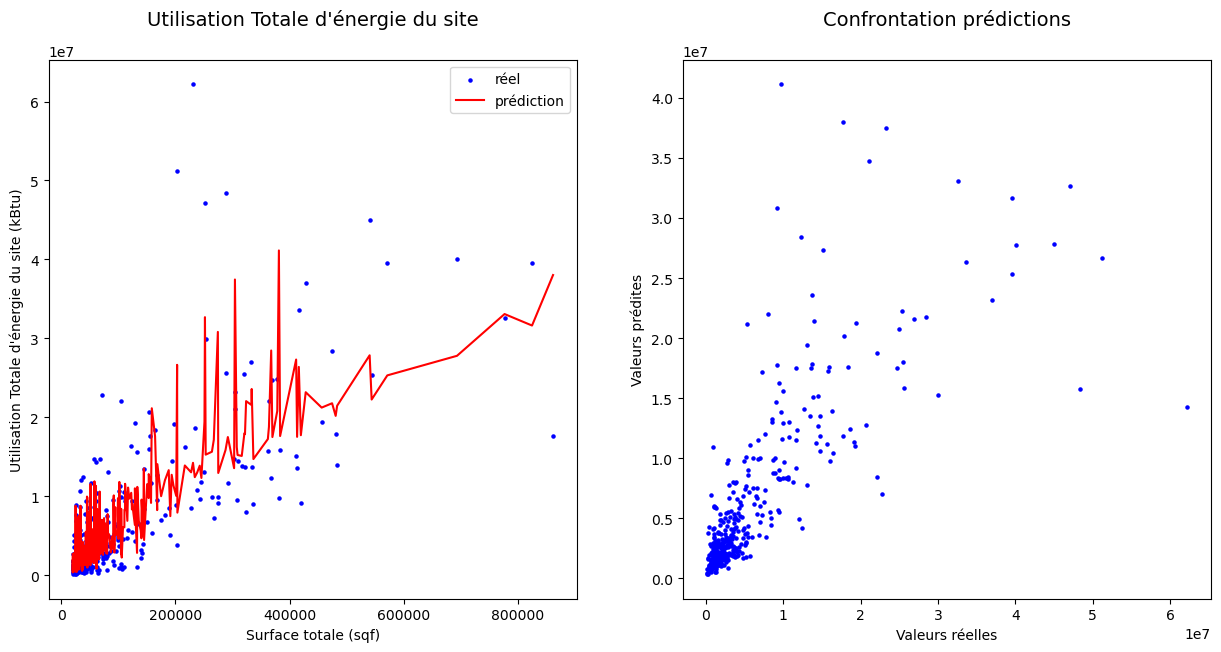

Modèle RandomForestRegressor random :
meilleurs paramètres : {'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': None}
Temps d'execution : 15.706s
Score train :0.95152
Score test  :0.60786
Mse :26997123948340.215
Rmse:5195875.66714


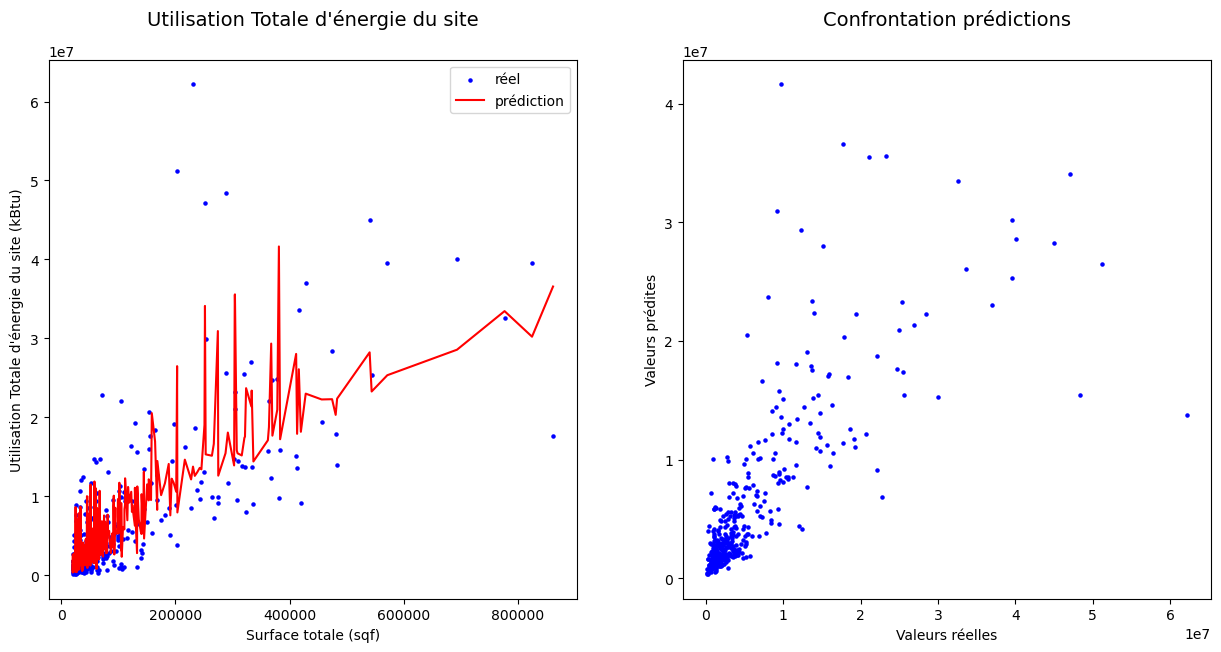

In [25]:
Result=TestModeles(dfDataInput_filtered,Modeles2Test)

### Résultats de la recherche du modèle et du tnning des Hyperparamètres

In [26]:
dfResult=pd.DataFrame(Result, columns=['Modèle', 'BaseScoreTrain', 'GridScoreTrain', 'RandScoreTrain',
                              'BaseScoreTest', 'GridScoreTest', 'RandScoreTest',
                              'BaseMse', 'GridMse', 'RandMse',
                              'BaseRmse', 'GridRmse', 'RandRmse',
                              'BaseTemps', 'GridTemps', 'RandTemps'])
dfResult

,Modèle,BaseScoreTrain,GridScoreTrain,RandScoreTrain,BaseScoreTest,GridScoreTest,RandScoreTest,BaseMse,GridMse,RandMse,BaseRmse,GridRmse,RandRmse,BaseTemps,GridTemps,RandTemps
0,LinearRegression,0.64961,0.64961,0.64961,0.58733,0.58733,0.58733,2.841071e+13,2.841059e+13,2.841059e+13,5.330170e+06,5.330159e+06,5.330159e+06,0.020,1.311,0.298
1,SVR,-0.14580,-0.14574,-0.14575,-0.14608,-0.14603,-0.14604,7.890374e+13,7.889980e+13,7.890066e+13,8.882778e+06,8.882556e+06,8.882604e+06,0.042,2.209,0.716
2,Lasso,0.64961,0.64961,0.64961,0.58733,0.58733,0.58733,2.841068e+13,2.841068e+13,2.841068e+13,5.330167e+06,5.330167e+06,5.330167e+06,0.174,0.795,2.732
3,Ridge,0.64867,0.64861,0.64861,0.59110,0.59134,0.59134,2.815144e+13,2.813509e+13,2.813509e+13,5.305793e+06,5.304252e+06,5.304252e+06,0.015,0.135,0.352
4,ElasticNet,0.54662,0.64193,0.64193,0.50556,0.59524,0.59524,3.404044e+13,2.786603e+13,2.786603e+13,5.834418e+06,5.278828e+06,5.278828e+06,0.016,1.145,2.290
5,GradientBoostingRegressor,0.88101,1.00000,1.00000,0.62814,0.28976,0.29503,2.560141e+13,4.889729e+13,4.853460e+13,5.059783e+06,6.992659e+06,6.966678e+06,0.330,32.057,83.389
6,RandomForestRegressor,0.95021,0.95266,0.95152,0.62458,0.61113,0.60786,2.584657e+13,2.677235e+13,2.699712e+13,5.083953e+06,5.174200e+06,5.195876e+06,1.504,28.890,15.706


## Modèle RandomForest optimisé 

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.95148
Score test:0.6065
R2  :0.6065
Mse :27091111716195.004
Rmse:5204912.26787


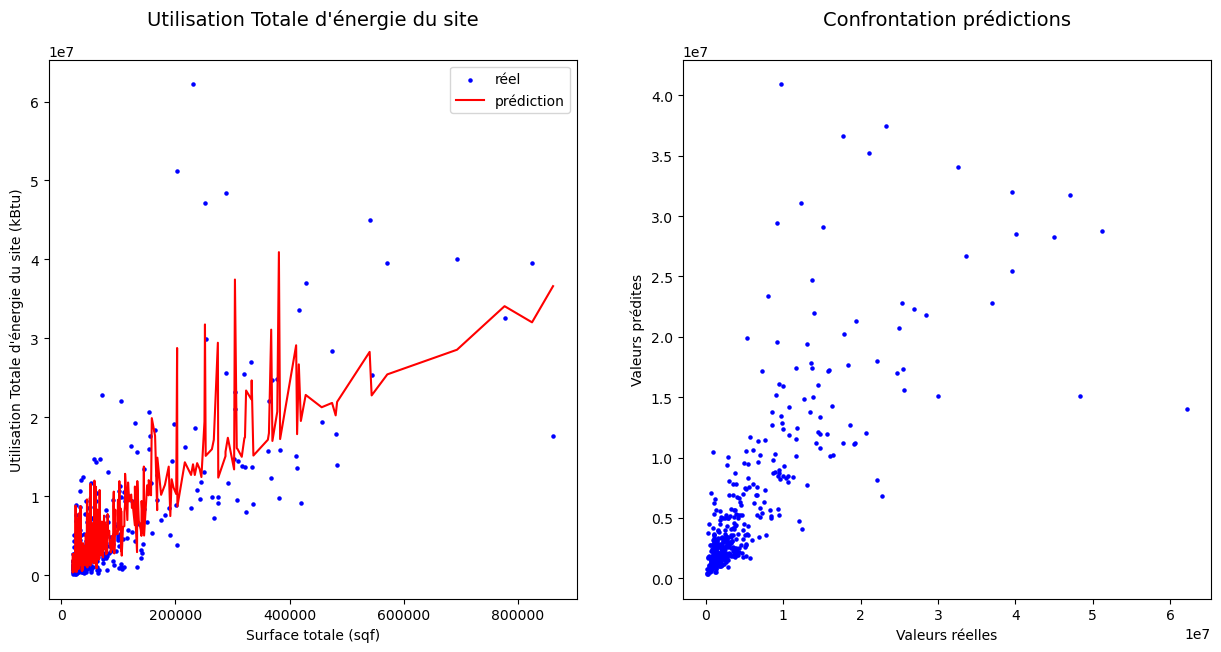

In [27]:
y = dfDataInput_filtered[Cible[1]]
X = dfDataInput_filtered.drop(Cible[1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=500, max_features=None, max_depth=None))
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')


## Analyse de l'importance des données

### Visualisation des principaux arbres avec Graphviz

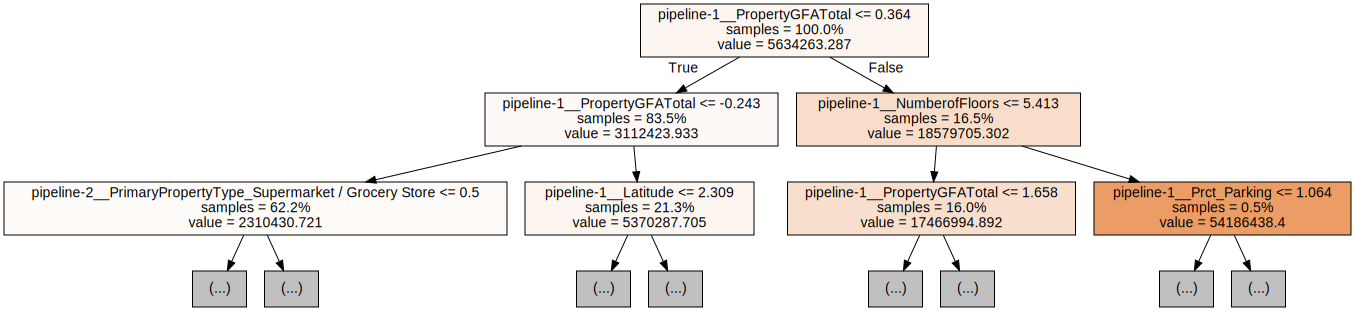

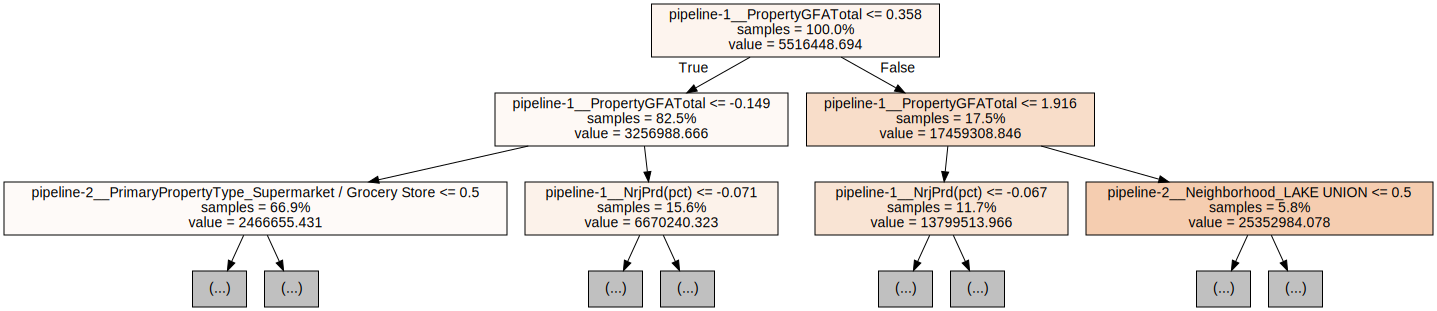

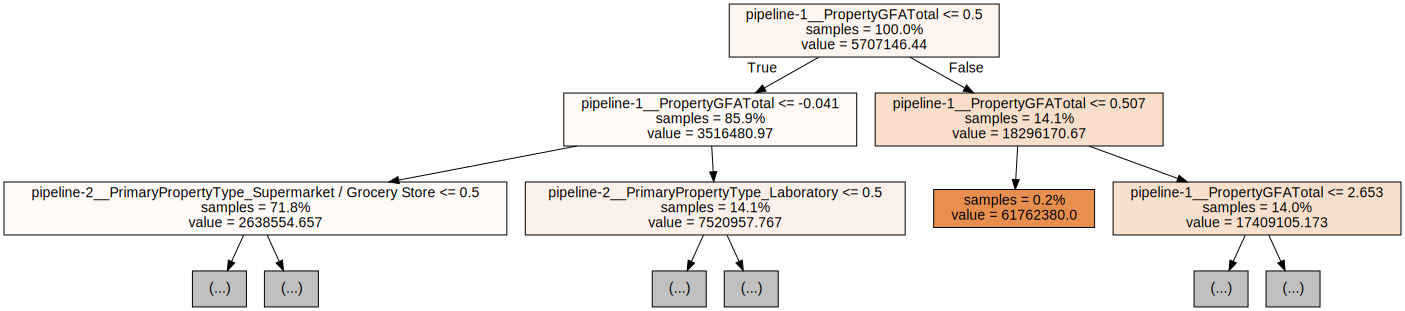

In [28]:
## ce module nécéssite l'installation du package graphviz
## avec la commande: apt-get install graphviz
## puis d'installer le module à l'aide de pip install
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
for i in range(3):
    tree = model.steps[1][1].estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=preprocessor.fit_transform(X_train).columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Diminution moyenne de l'impureté (MDI)

Visualisation de l\importance des variables sous forme numérique :
PropertyGFATotal                                   0.622944
NrjPrd(pct)                                        0.057371
NumberofFloors                                     0.041662
PrimaryPropertyType_Mixed Use Property             0.034326
NrjGaz(pct)                                        0.028634
Latitude                                           0.028500
NrjElc(pct)                                        0.024642
Longitude                                          0.024262
PrimaryPropertyType_Laboratory                     0.020915
AgeBuilding                                        0.019948
Prct_Parking                                       0.015897
PrimaryPropertyType_Supermarket / Grocery Store    0.014563
NumberofBuildings                                  0.010856
NrjVap(pct)                                        0.007327
PrimaryPropertyType_Warehouse                      0.006435
PrimaryPropertyType_Other        

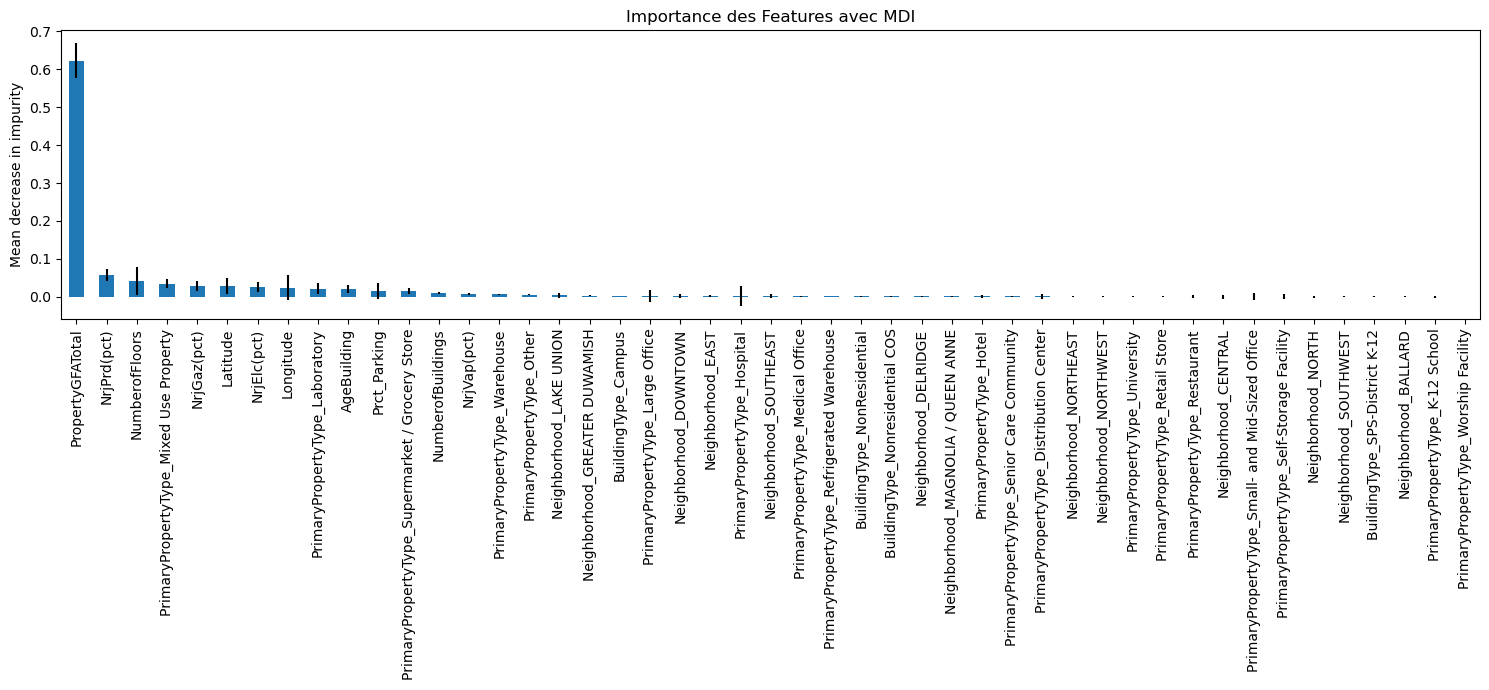

In [29]:
ImportanceFeaturesMDI(model.steps[1][1],Affnum=1)

### Calcul de l'importance des variables avec SHAP

In [30]:
check_additivity = False

X_train_shap = preprocessor.fit_transform(X_train)
X_test_shap = preprocessor.fit_transform(X_test)
model_shap = model.steps[1][1]

feature_names=X_train_shap.columns
changeChars=[('pipeline-1__',''),('pipeline-2__','')]
for rech, trgt in changeChars:
    feature_names = [name.replace(rech,trgt) for name in feature_names]

explainer = shap.TreeExplainer(model_shap, feature_names=feature_names)
single_shap_value = explainer(X_test_shap.sample(n=1), check_additivity=check_additivity)
shap_values = explainer(X_test_shap, check_additivity=check_additivity)

#### Impact moyen des variables sur la sortie

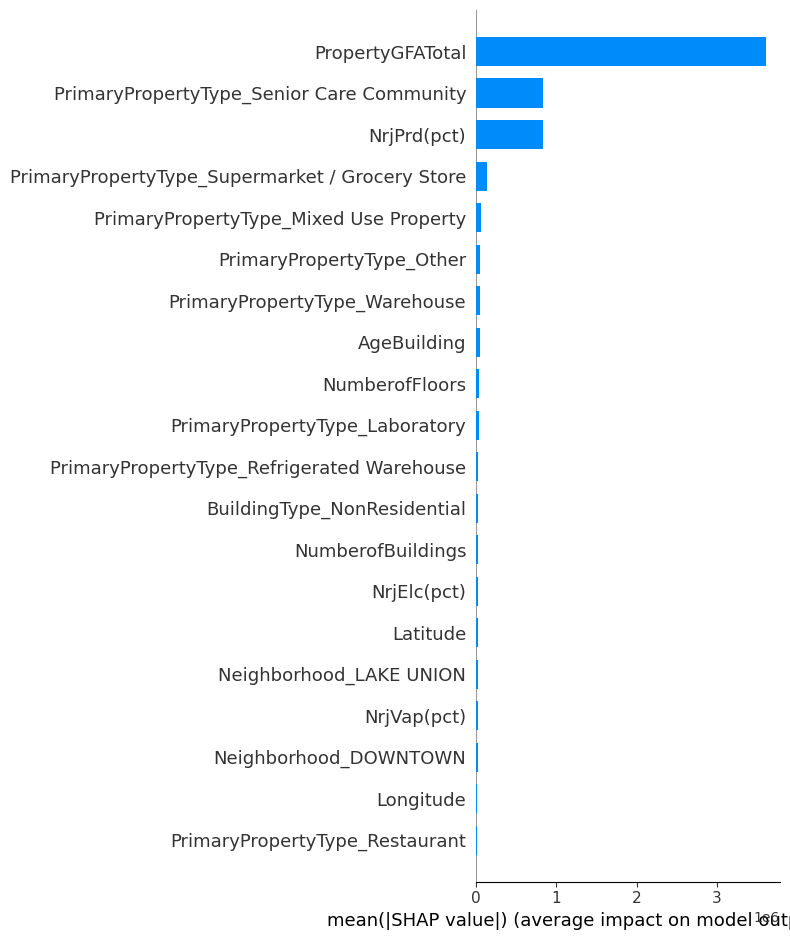

In [31]:
shap.summary_plot(single_shap_value, feature_names=feature_names, plot_type='bar')

#### Impact moyen des variables sur la sortie

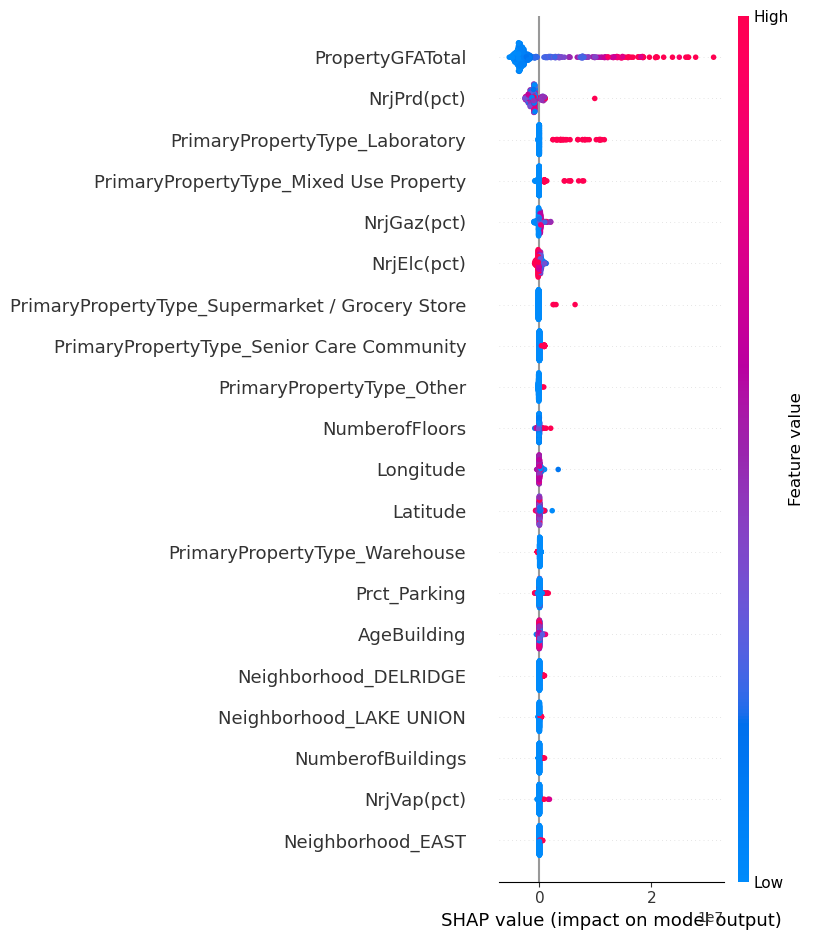

In [33]:
shap.summary_plot(shap_values, feature_names=feature_names)

#### Waterfall sur l'importance des variables

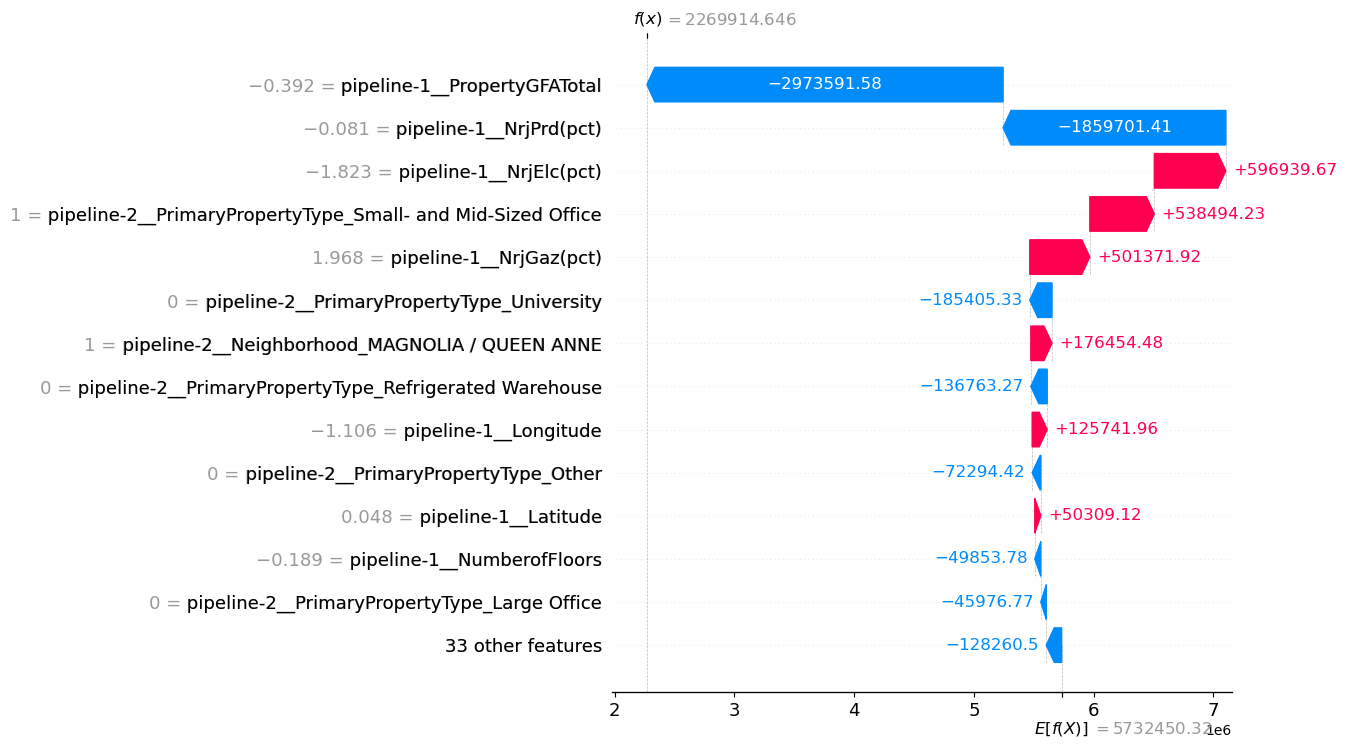

In [34]:
shap.plots.waterfall(shap_values[0], max_display=14)

#### Heatmap sur l'importance des variables

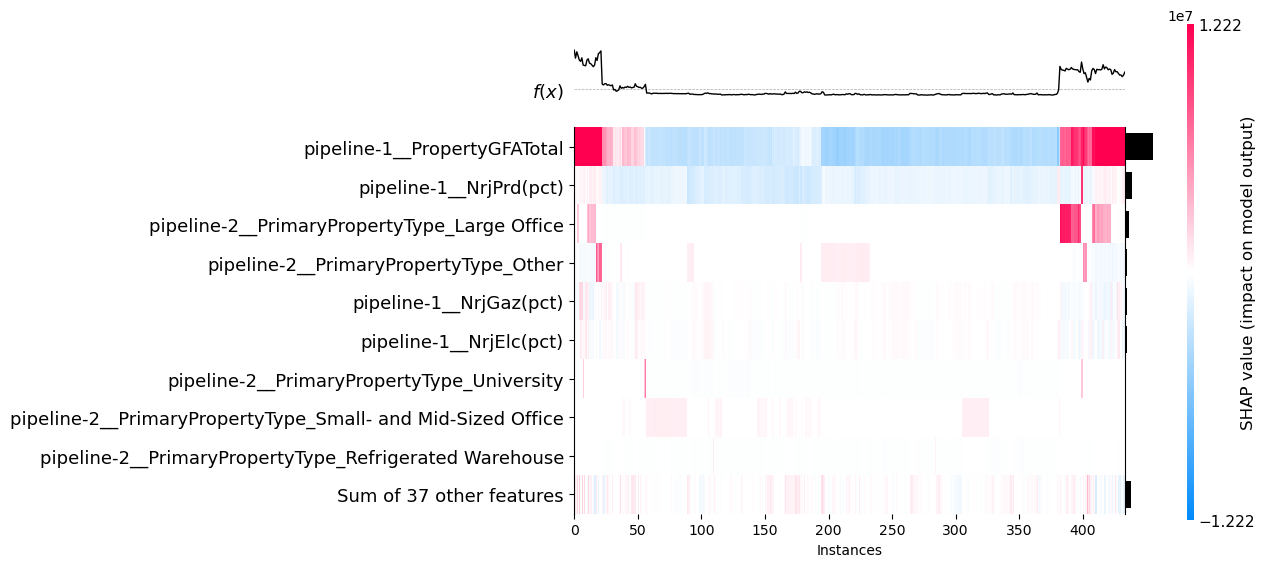

<Axes: xlabel='Instances'>

In [35]:
shap.plots.heatmap(shap_values)

## Analyse de l'importance de l'energy star score

### selection des données

In [44]:
dfDataNrjScore=dfDataInput_filtered.loc[~dfDataInput_filtered['ENERGYSTARScore'].isna()].copy()
y = dfDataNrjScore[Cible[1]]
X = dfDataNrjScore.drop(Cible[1], axis=1)
ResultES=[]

### Modèlisation RandomForest sans EnergyStar (réference)

Temps d'execution : 0s
Score train :0.96621
Score test  :0.62976
Mse :16470639476223.865
Rmse:4058403.56251


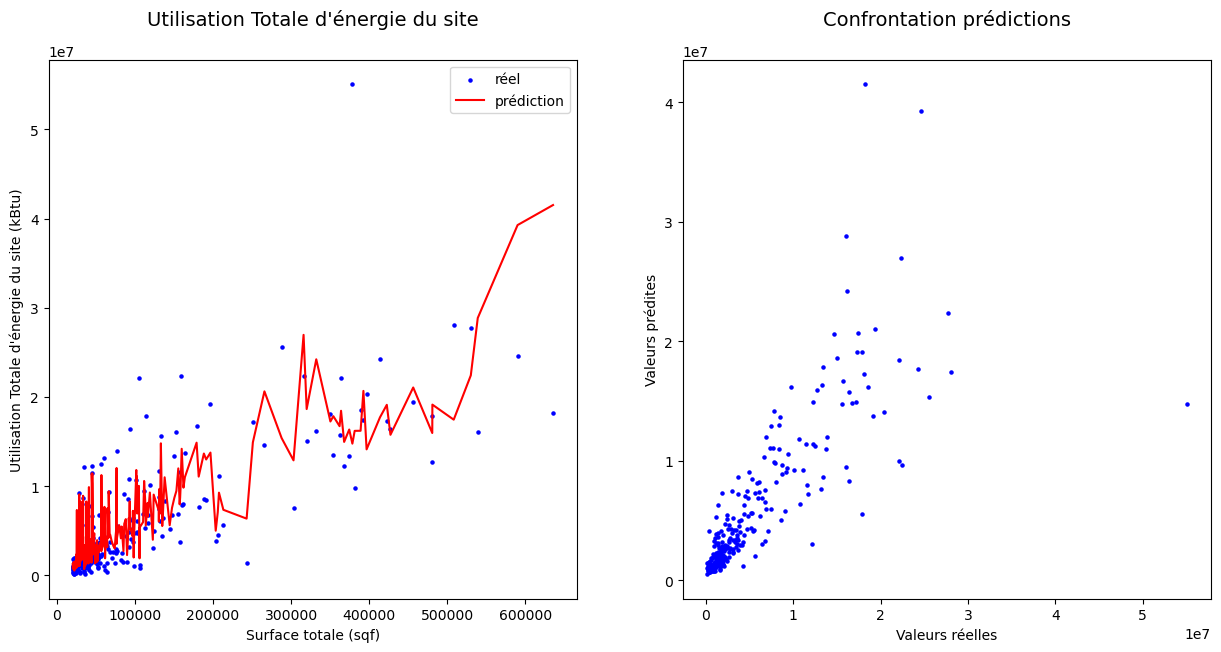

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=1000, max_features=None, max_depth=None))
#print(model)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ScoreSansEs=scores2(model,X_train,X_test,y_train,y_test,y_pred,0)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')
ResultES.append(['Sans EnergyStarScore',ScoreSansEs[0],ScoreSansEs[1],ScoreSansEs[2],ScoreSansEs[3]])

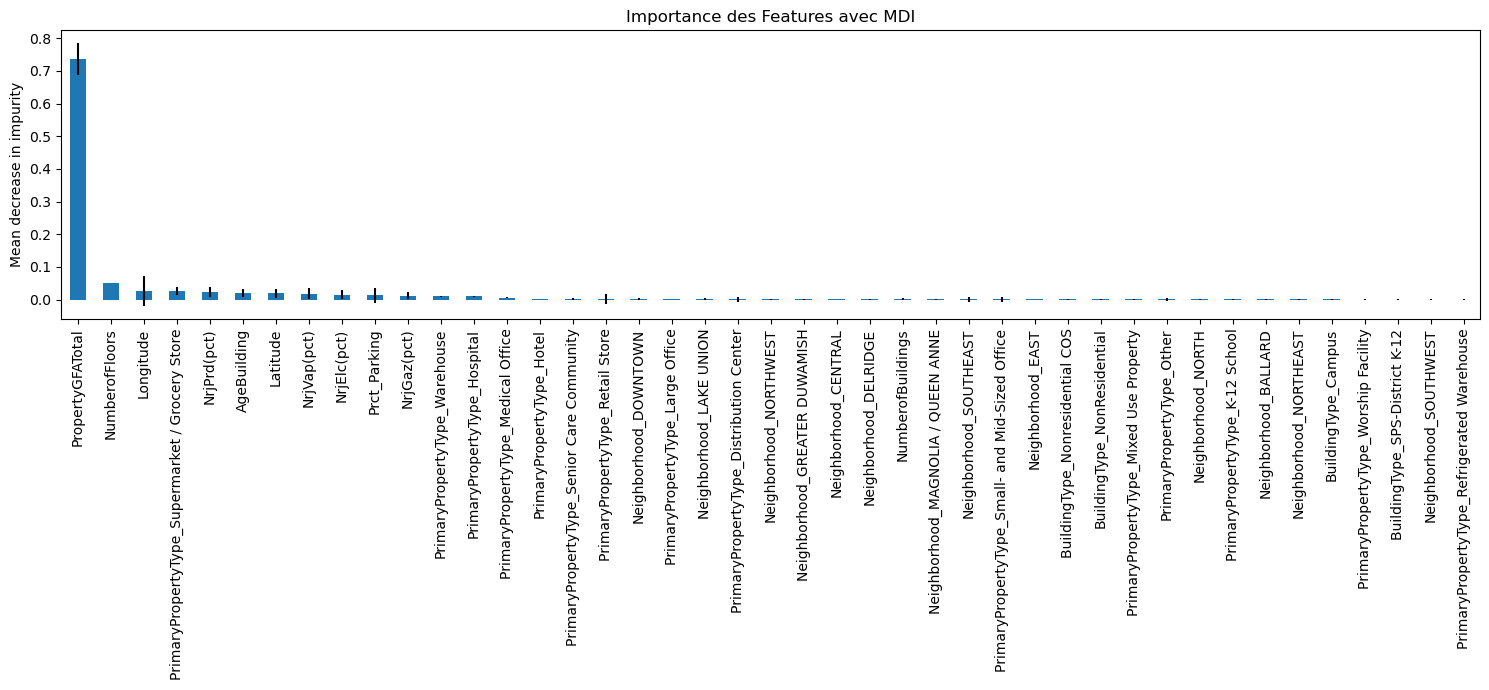

In [46]:
ImportanceFeaturesMDI(model.steps[1][1])

### Modèlisation RandomForest avec EnergyStar

Temps d'execution : 0s
Score train :0.97376
Score test  :0.66767
Mse :14783886782817.156
Rmse:3844982.02633


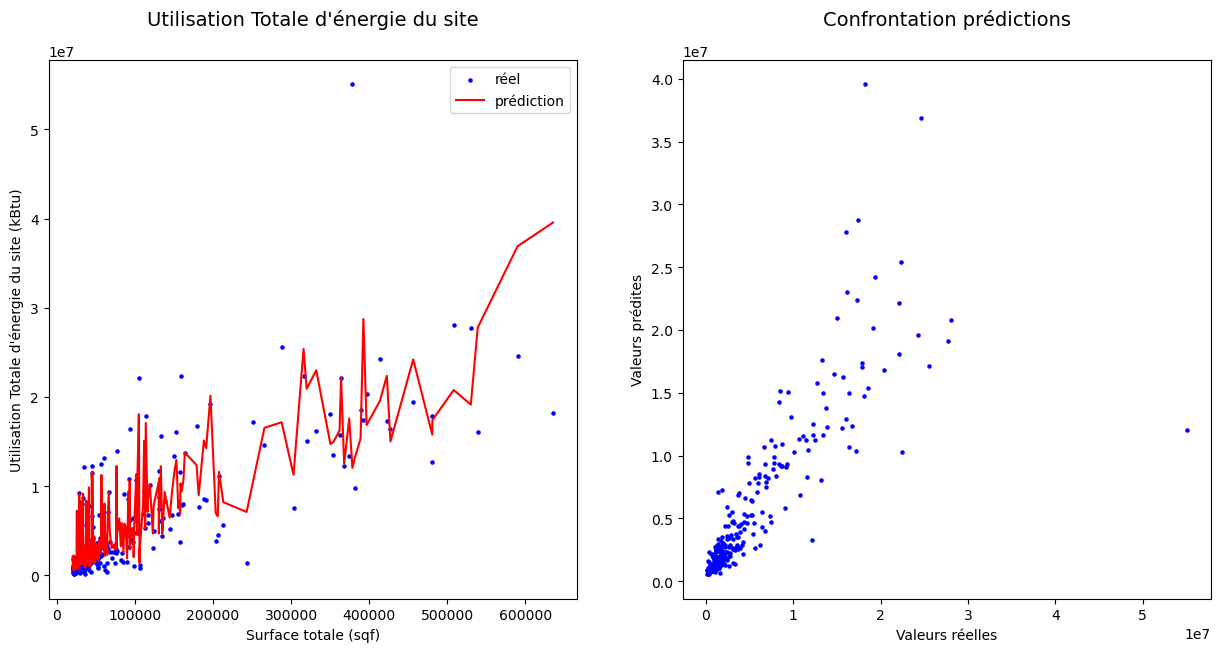

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)','ENERGYSTARScore']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=1000, max_features=None, max_depth=None))
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ScoreAvecEs=scores2(model,X_train,X_test,y_train,y_test,y_pred,0)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')
ResultES.append(['Avec EnergyStarScore',ScoreAvecEs[0],ScoreAvecEs[1],ScoreAvecEs[2],ScoreAvecEs[3]])

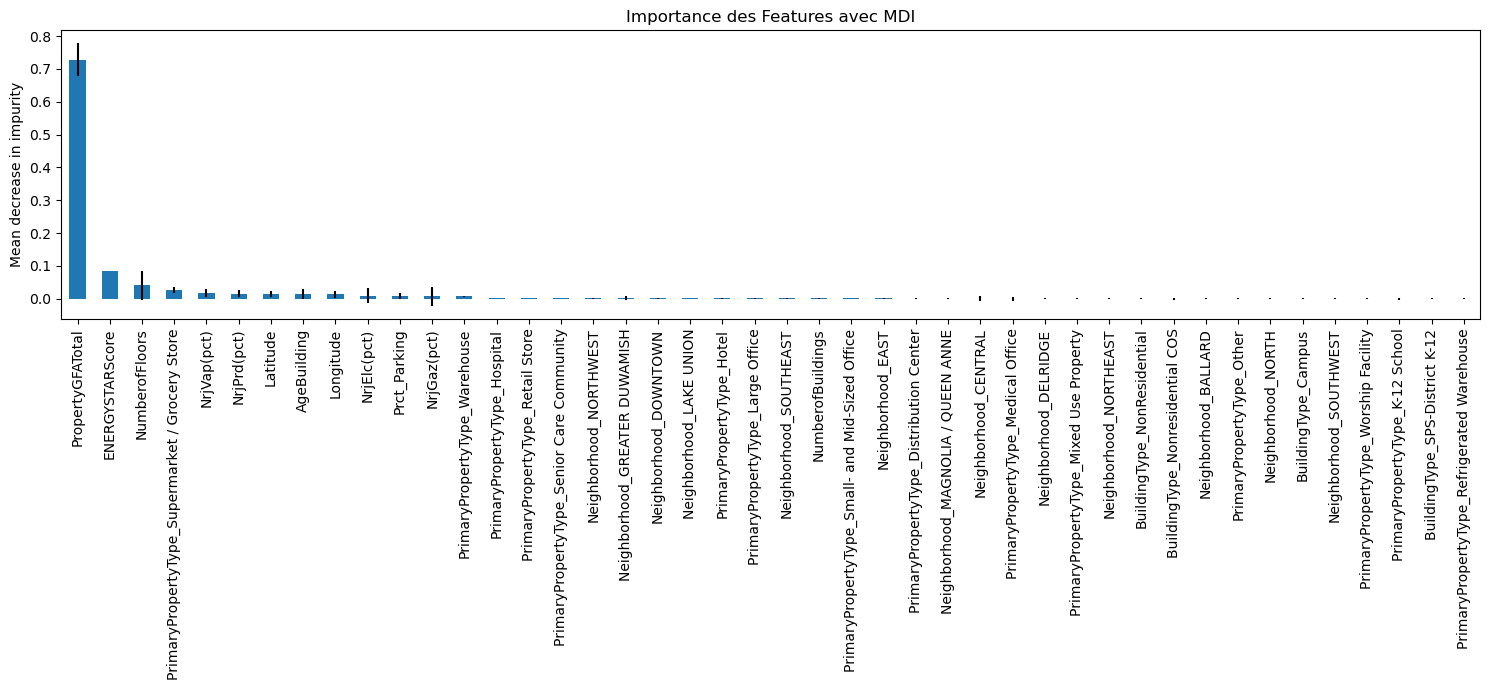

In [48]:
ImportanceFeaturesMDI(model.steps[1][1])

In [50]:
dfResultES=pd.DataFrame(ResultES, columns=['Modèle consommation énergie', 'ScoreTrain', 'ScoreTest', 'Mse', 'Rmse'])
dfResultES

,Modèle consommation énergie,ScoreTrain,ScoreTest,Mse,Rmse
0,Sans EnergyStarScore,0.96621,0.62976,1.647064e+13,4.058404e+06
1,Avec EnergyStarScore,0.97376,0.66767,1.478389e+13,3.844982e+06
